<a href="https://colab.research.google.com/github/josefinavanotti/josefinavanotti/blob/main/TESINA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (12, 7)}) #para estandarizar el tamaño de todos los gráficos
sns.set_theme() # aplica el tema estándar visual de los gráficos
%matplotlib inline
#para que al exportar el código los gráficos queden bien presentados
# Machine Learning
import xgboost as xgb
from sklearn.model_selection import train_test_split
# Métricas de evaluación de mmodelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# EVT --- Distribución Generalizada de Pareto para la cola de la distribución
from scipy.stats import genpareto, lognorm
from scipy.optimize import bisect #método de bisección para encontrar raíces de ecuaciones numéricamente (en este caso, para encontrar el VaR)
# Utilidad de ejes
from matplotlib.ticker import FuncFormatter #función personalizada para formatear los números de los ejes en los gráficos
# reproducibilidad simple
import random
def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
!pip install category-encoders
from category_encoders import TargetEncoder


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 1.9 MB/s eta 0:00:00


# 📊 Preparación de los datos

In [3]:
df = pd.read_csv("/content/dataset_tesis.csv")
df = pd.DataFrame(df)
df.head()

,ID,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,...,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG
0,63581743,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,...,11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0
1,132761049,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,...,1,Minivan,yes,$0,0,No,0,$0,1.0,0
2,921317019,0,48.0,0,11.0,"$52,881",No,$0,z_No,M,...,1,Van,yes,$0,0,No,2,$0,10.0,0
3,727598473,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,...,4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0
4,450221861,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,...,7,Minivan,yes,$0,0,No,0,$0,6.0,0


In [4]:
df.shape

(10302, 25)

In [5]:
df.isna().sum()

,0
ID,0
KIDSDRIV,0
AGE,7
HOMEKIDS,0
YOJ,548
INCOME,570
PARENT1,0
HOME_VAL,575
MSTATUS,0
GENDER,0


Columnas con NaN: INCOME, YOJ, HOME_VAL, OCCUPATION, CAR_AGE

In [6]:
# Limpieza de caracteres especiales
df = df.applymap(lambda x: x.replace('$', '') if isinstance(x, str) else x)
df = df.replace(to_replace=r'^z_', value='', regex=True)
df = df.applymap(lambda x: x.replace(',', '') if isinstance(x, str) else x)
df

/tmp/ipython-input-3303880705.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace('$', '') if isinstance(x, str) else x)
/tmp/ipython-input-3303880705.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace(',', '') if isinstance(x, str) else x)


,ID,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,...,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG
0,63581743,0,60.0,0,11.0,67349,No,0,No,M,...,11,Minivan,yes,4461,2,No,3,0,18.0,0
1,132761049,0,43.0,0,11.0,91449,No,257252,No,M,...,1,Minivan,yes,0,0,No,0,0,1.0,0
2,921317019,0,48.0,0,11.0,52881,No,0,No,M,...,1,Van,yes,0,0,No,2,0,10.0,0
3,727598473,0,35.0,1,10.0,16039,No,124191,Yes,F,...,4,SUV,no,38690,2,No,3,0,10.0,0
4,450221861,0,51.0,0,14.0,NaN,No,306251,Yes,M,...,7,Minivan,yes,0,0,No,0,0,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,67790126,1,45.0,2,9.0,164669,No,386273,Yes,M,...,15,Minivan,no,0,0,No,2,0,17.0,0
10298,61970712,0,46.0,0,9.0,107204,No,332591,Yes,M,...,6,Panel Truck,no,0,0,No,0,0,1.0,0
10299,849208064,0,48.0,0,15.0,39837,No,170611,Yes,F,...,7,SUV,no,0,0,No,0,0,1.0,0
10300,627828331,0,50.0,0,7.0,43445,No,149248,Yes,F,...,6,Minivan,no,0,0,No,0,0,11.0,0


In [7]:
# Conversión de columnas numéricas: si la columna es categórica, intento convertirla a float.
for i in df.columns:
    if df[i].dtypes == "object":
        try:
            df[i] = df[i].astype(float)
        except:
            pass

In [8]:
# me creo un DF con frecuencia y severidad
df_freq_sev = df.groupby('ID').agg({'CLAIM_FLAG': 'sum', 'CLM_AMT': 'mean'}) #agrupo todo por ID, o sea por póliza
# o sea para las pólizas que tienen más de un registro agrupo y uso sus valores promedios
# CLAIM FLAG: ejemplo, si un cliente tiene 3 registros y 1 siniestro → frecuencia = 1/3 = 0.33.
# CLM_AMT: monto promedio de siniestro
df_freq_sev = df_freq_sev.reset_index()
df_freq_sev.columns  = ['ID', 'FREQUENCY', 'SEVERITY']
df_freq_sev

,ID,FREQUENCY,SEVERITY
0,63175,0,0.0
1,246910,0,0.0
2,401276,0,0.0
3,813128,0,0.0
4,1307371,0,0.0
...,...,...,...
8748,999482663,0,0.0
8749,999577084,0,0.0
8750,999640290,0,0.0
8751,999800537,0,0.0


In [9]:
#  Combino mi df agrupado por poliza con mi df inicial
df_merged = df.drop(columns = ['CLAIM_FLAG', 'CLM_AMT'])

# Then merge with the df_freq_sev
df_final = pd.merge(left = df_freq_sev, right=df_merged, how = 'left', on = 'ID')
df_final


,ID,FREQUENCY,SEVERITY,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE
0,63175,0,0.0,0,50.0,0,8.0,NaN,No,282453.0,...,Private,16740.0,4,Minivan,no,0.0,0,Yes,0,14.0
1,246910,0,0.0,0,33.0,1,8.0,53598.0,Yes,NaN,...,Private,11410.0,1,SUV,no,9867.0,4,No,1,1.0
2,401276,0,0.0,0,53.0,0,13.0,23847.0,No,108261.0,...,Private,17970.0,7,SUV,no,0.0,0,No,2,14.0
3,813128,0,0.0,0,44.0,2,15.0,NaN,No,186500.0,...,Commercial,10600.0,17,Pickup,no,0.0,0,No,0,7.0
4,813128,0,0.0,1,46.0,0,12.0,45018.0,No,0.0,...,Private,15060.0,4,Minivan,no,33026.0,3,No,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,999577084,0,0.0,0,56.0,0,10.0,99606.0,No,NaN,...,Private,9050.0,6,Pickup,no,0.0,0,No,0,12.0
10298,999640290,0,0.0,2,45.0,2,13.0,33464.0,No,153488.0,...,Private,6000.0,6,Pickup,yes,2883.0,1,No,7,1.0
10299,999800537,0,0.0,0,45.0,0,12.0,71076.0,No,216234.0,...,Private,8610.0,5,SUV,no,3300.0,1,No,2,NaN
10300,999926368,0,0.0,0,46.0,0,11.0,57456.0,No,207400.0,...,Private,12520.0,6,Minivan,yes,0.0,0,No,0,6.0


In [10]:
# Saco los duplicados
df_final.drop_duplicates(inplace= True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10301 entries, 0 to 10301
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10301 non-null  int64  
 1   FREQUENCY   10301 non-null  int64  
 2   SEVERITY    10301 non-null  float64
 3   KIDSDRIV    10301 non-null  int64  
 4   AGE         10294 non-null  float64
 5   HOMEKIDS    10301 non-null  int64  
 6   YOJ         9753 non-null   float64
 7   INCOME      9731 non-null   float64
 8   PARENT1     10301 non-null  object 
 9   HOME_VAL    9726 non-null   float64
 10  MSTATUS     10301 non-null  object 
 11  GENDER      10301 non-null  object 
 12  EDUCATION   10301 non-null  object 
 13  OCCUPATION  9636 non-null   object 
 14  TRAVTIME    10301 non-null  int64  
 15  CAR_USE     10301 non-null  object 
 16  BLUEBOOK    10301 non-null  float64
 17  TIF         10301 non-null  int64  
 18  CAR_TYPE    10301 non-null  object 
 19  RED_CAR     10301 non-null  ob

In [11]:
# Imputo los NaN
# Uso la mediana para numéricas y "Desconocido" para categóricas.
for col in df_final.columns:
    if df_final[col].dtype in ["float64", "int64"]:
        df_final[col] = df_final[col].fillna(df_final[col].median())
    else:
        df_final[col] = df_final[col].fillna(df_final[col].mode())
df_final.isna().sum()

,0
ID,0
FREQUENCY,0
SEVERITY,0
KIDSDRIV,0
AGE,0
HOMEKIDS,0
YOJ,0
INCOME,0
PARENT1,0
HOME_VAL,0


In [12]:
df_final.shape

(10301, 25)

In [13]:
from scipy.stats import pearsonr, spearmanr
# --- util: correlation ratio (eta) para categórica vs numérica ---
def correlation_ratio_cat_num(categories, values):
    # categories: Serie categórica (str/object/category)
    # values: Serie numérica
    # devuelve eta en [0,1]
    cat = pd.Categorical(categories)
    y = pd.Series(values).astype(float)
    mask = (~pd.isna(cat.codes)) & (~y.isna())
    codes = cat.codes[mask]
    y = y[mask]
    overall_mean = y.mean()
    # between-groups
    ss_between = 0.0
    for k in range(len(cat.categories)):
        yk = y[codes == k]
        if len(yk) > 0:
            ss_between += len(yk) * (yk.mean() - overall_mean) ** 2
    # total
    ss_total = ((y - overall_mean) ** 2).sum()
    if ss_total <= 0:
        return np.nan
    eta = np.sqrt(ss_between / ss_total)
    return float(eta)
def correlations_vs_targets_simple(df, targets=("FREQUENCY","SEVERITY")):
    """Calcula y consolida el coeficiente final (Pearson o Eta) por feature."""

    # 1. Separar tipos de columnas
    num_cols = [c for c in df.columns if c not in targets and pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in df.columns if c not in targets and not pd.api.types.is_numeric_dtype(df[c])]

    out_rows = []

    for tgt in targets:
        y = df[tgt]

        # 2. Numéricas: Coeficiente Pearson
        for col in num_cols:
            x = df[col]
            mask = ~(x.isna() | y.isna())
            r = np.nan
            if mask.sum() >= 3:
                r, _ = pearsonr(x[mask], y[mask])

            # Almacenar el resultado en el campo 'score'
            out_rows.append({"feature": col, "target": tgt, "score": r})

        # 3. Categóricas: Coeficiente Eta
        for col in cat_cols:
            eta = correlation_ratio_cat_num(df[col], y) # Asume que esta función está definida

            # Almacenar el resultado en el campo 'score'
            out_rows.append({"feature": col, "target": tgt, "score": eta})

    # Devolver un DataFrame con solo feature, target, y score
    res = pd.DataFrame(out_rows)
    return res
corr_table = correlations_vs_targets_simple(df_final, targets=("FREQUENCY","SEVERITY"))
# === PROCESAMIENTO FINAL Y SALIDA ===

# 1. Seleccionar y Ordenar para FREQUENCY
top_freq = (corr_table[corr_table["target"]=="FREQUENCY"]
            .sort_values("score", ascending=False))

# 2. Seleccionar y Ordenar para SEVERITY
top_sev = (corr_table[corr_table["target"]=="SEVERITY"]
            .sort_values("score", ascending=False))

# --- SALIDA MÍNIMA REQUERIDA ---

# Salida para FREQUENCY
print("\n=== TOP CORRELATIONS VS. FREQUENCY ===")
# Muestra solo el nombre de la columna y el coeficiente (score)
for _, row in top_freq[["feature", "score"]].head(10).iterrows():
    print(f"{row['feature']}: {row['score']:.4f}")

# Salida para SEVERITY
print("\n=== TOP CORRELATIONS VS. SEVERITY ===")
# Muestra solo el nombre de la columna y el coeficiente (score)
for _, row in top_sev[["feature", "score"]].head(10).iterrows():
    print(f"{row['feature']}: {row['score']:.4f}")




=== TOP CORRELATIONS VS. FREQUENCY ===
MVR_PTS: 0.2029
CLM_FREQ: 0.1981
OCCUPATION: 0.1900
EDUCATION: 0.1609
PARENT1: 0.1570
REVOKED: 0.1403
MSTATUS: 0.1377
OLDCLAIM: 0.1267
HOMEKIDS: 0.1211
CAR_USE: 0.1205

=== TOP CORRELATIONS VS. SEVERITY ===
MVR_PTS: 0.1405
CLM_FREQ: 0.1228
OCCUPATION: 0.1078
PARENT1: 0.1050
MSTATUS: 0.0910
CAR_USE: 0.0890
OLDCLAIM: 0.0784
HOMEKIDS: 0.0751
EDUCATION: 0.0743
KIDSDRIV: 0.0729


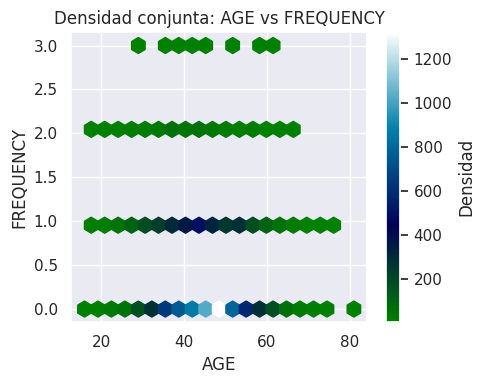

In [14]:
def hist_num_vs_num(df, var_x, var_y, gridsize=20):
    plt.figure(figsize=(5, 4))
    plt.hexbin(df[var_x], df[var_y], gridsize=gridsize, cmap="ocean", mincnt=1)
    plt.colorbar(label='Densidad')
    plt.xlabel(var_x)
    plt.ylabel(var_y)
    plt.title(f"Densidad conjunta: {var_x} vs {var_y}")
    plt.tight_layout()
    plt.show()
hist_num_vs_num(df_final, "AGE", "FREQUENCY")

def hist_num_vs_cat(df, var_num, var_cat, bins=20):
    plt.figure(figsize=(6, 4))
    categorias = df[var_cat].dropna().unique()

    for cat in categorias:
        subset = df[df[var_cat] == cat][var_num].dropna()
        plt.hist(subset, bins=bins, alpha=0.6, label=f"{var_cat}={cat}")

    plt.title(f"Distribución de {var_num} según {var_cat}")
    plt.xlabel(var_num)
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


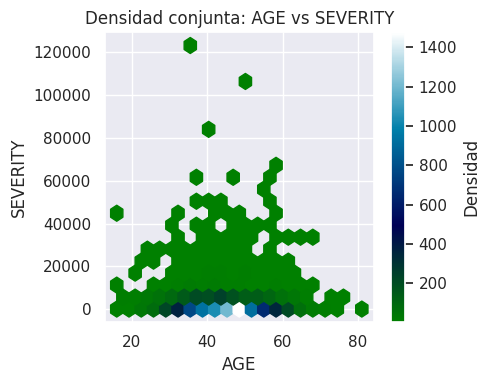

In [15]:
hist_num_vs_num(df_final, "AGE", "SEVERITY")

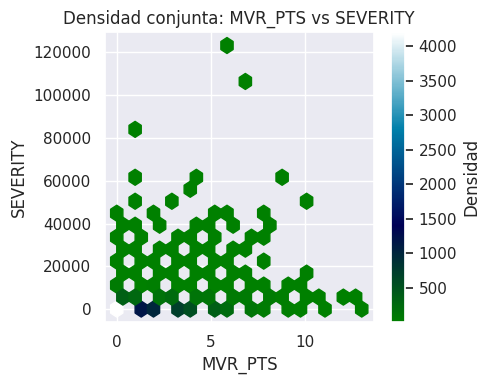

In [16]:
hist_num_vs_num(df_final, "MVR_PTS", "SEVERITY")

In [17]:
# columnas con mayor poder explicativo
columnas_deseadas = [
    'MVR_PTS',
    'CLM_FREQ',
    'OCCUPATION',
    'EDUCATION',
    'PARENT1',
    'REVOKED',
    'MSTATUS',
    'OLDCLAIM',
    'HOMEKIDS',
    'CAR_USE',
    'AGE',
    'FREQUENCY',
    'SEVERITY',
    'ID'
]

df_final = df_final[columnas_deseadas]
print("Columnas en el nuevo df_final:")
print(df_final.columns.tolist())
print(f"Nueva forma del DataFrame: {df_final.shape}")

Columnas en el nuevo df_final:
['MVR_PTS', 'CLM_FREQ', 'OCCUPATION', 'EDUCATION', 'PARENT1', 'REVOKED', 'MSTATUS', 'OLDCLAIM', 'HOMEKIDS', 'CAR_USE', 'AGE', 'FREQUENCY', 'SEVERITY', 'ID']
Nueva forma del DataFrame: (10301, 14)


TRAIN TEST SPLIT


In [18]:
train_data, test_data = train_test_split(df_final, test_size=0.2, random_state=42)


In [19]:
def create_xgb_model(params):
    return xgb.XGBRegressor(**params)

-------------------------------------------------

# **MODELO DE FRECUENCIA**

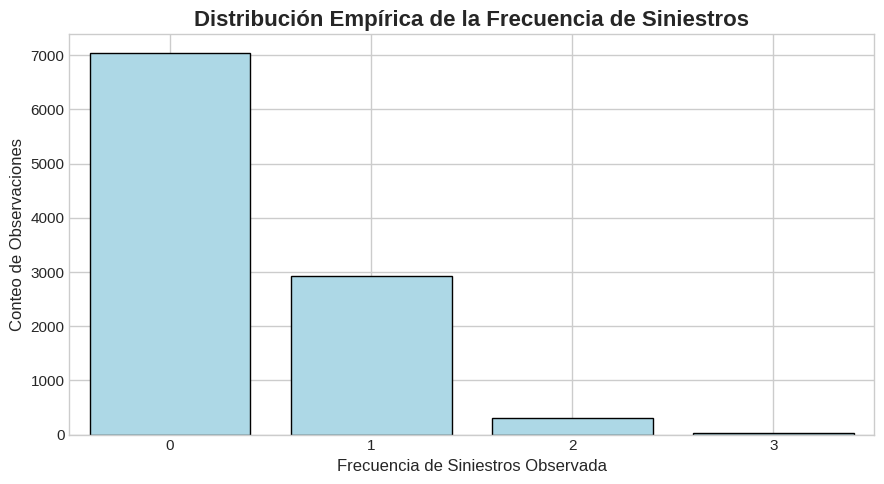

In [20]:
import matplotlib.ticker as ticker
counts = df_final['FREQUENCY'].value_counts().sort_index()
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(9, 5))

plt.bar(
    counts.index,
    counts.values,
    width=0.8,
    color='lightblue',
    edgecolor='black'
)

plt.xticks(
    counts.index, # Posiciones de los ticks (centradas automáticamente)
    labels=counts.index.astype(int) # Los labels son los valores de frecuencia
)

# 5. Etiquetas y Títulos Académicos
plt.title(
    'Distribución Empírica de la Frecuencia de Siniestros',
    fontsize=16,
    fontweight='bold'
)
plt.xlabel('Frecuencia de Siniestros Observada', fontsize=12)
plt.ylabel('Conteo de Observaciones', fontsize=12)
plt.xlim(left=-0.5, right=counts.index.max() + 0.5)

plt.tight_layout()
plt.show()

In [21]:
def preprocess_for_freq(train_data, test_data):
    # 1) X / y
    X_train = train_data.drop(['FREQUENCY', 'ID', 'SEVERITY'], axis=1).copy() #elimino todas las columnas que no se usan como explicativas del modelo
    y_train = train_data['FREQUENCY'].copy()

    X_test  = test_data.drop(['FREQUENCY', 'ID', 'SEVERITY'], axis=1).copy()
    y_test  = test_data['FREQUENCY'].copy()
#variables categóricas vs. numéricas
    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist() #columnas explicativas categóricas
    num_cols = [c for c in X_train.columns if c not in cat_cols] #columnas explicativas numéricas

#Target Encoding SOLO en categóricas.
# lo que hace el target encoding es que dentro de los distintos valores que puede tomar una columna, al valor categórico que tiene mayor frecuencia lo reemplaza un número mayor.
    if len(cat_cols) > 0:
        encoder = TargetEncoder(
            cols=cat_cols,
            smoothing=10,            # suaviza vs media global
            min_samples_leaf=50,     # evita overfitting
            handle_unknown='value',
            handle_missing='value'
        )
        X_train_cat = encoder.fit_transform(X_train[cat_cols], y_train)
        X_test_cat  = encoder.transform(X_test[cat_cols])
    else:
        X_train_cat = pd.DataFrame(index=X_train.index)
        X_test_cat  = pd.DataFrame(index=X_test.index)

    # Combino numéricas + categóricas codificadas reemplazadas por números
    X_train_encoded = pd.concat(
        [X_train[num_cols].reset_index(drop=True),
         X_train_cat.reset_index(drop=True)],
        axis=1
    )
    X_test_encoded = pd.concat(
        [X_test[num_cols].reset_index(drop=True),
         X_test_cat.reset_index(drop=True)],
        axis=1
    )

    return X_train_encoded, X_test_encoded, y_train, y_test


def train_test_freq(model, train_data, test_data):
    X_train, X_test, y_train, y_test = preprocess_for_freq(train_data, test_data) #llama a la función que prepara los datos
    # Control para ver si el split train/test quedó balanceado --- (que no haya diferencia grande entre las medias)
    print('--- Validación de la División en train y test (y) ---')
    print(f'Media y_train: {y_train.mean():.6f}')
    print(f'Media y_test:  {y_test.mean():.6f}')
    print('-------------------------------------')
# Entrenamiento del modelo
    model_fit = model.fit(X_train, y_train) #entreno/ajusto el modelo con un regresor, en este caso XGBoost
    y_pred = model_fit.predict(X_test) #Genera predicciones de frecuencia para los datos de TEST
#--- Métricas
    bias_pct = (y_pred.mean() - y_test.mean()) / max(y_test.mean(), 1e-12) #métrica para ver si se sobreestima o subestima la media
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = (mean_absolute_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f'Sesgo de la media: {100*bias_pct:.3f}%')
    print(f'RMSE: {rmse:.6f}')
    print(f'MAE: {mae:.6f}')
    print(f'R²: {r2:.4f}')

    return model_fit, y_pred, y_test


In [22]:
xgb_freq_params = {
    'objective': 'count:poisson',  # para FREQUENCY en [0,1]
    'learning_rate': 0.05,
    'max_depth': 5,
    'n_estimators': 250,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1.0,
    'random_state': 42
}
xgb_freq_model = create_xgb_model(xgb_freq_params)

In [23]:
model_freq, preds_freq, y_test_freq = train_test_freq(xgb_freq_model, train_data, test_data)
print('--- Valor esperado real de la frecuencia de una póliza ---')
print(f'Media real: {df_final['FREQUENCY'].mean():.6f}')

--- Validación de la División en train y test (y) ---
Media y_train: 0.350728
Media y_test:  0.361475
-------------------------------------
Sesgo de la media: -3.081%
RMSE: 0.518716
MAE: 0.402989
R²: 0.1331
--- Valor esperado real de la frecuencia de una póliza ---
Media real: 0.352878


In [24]:
df_completo = test_data.copy()

# Convertimos a numpy (garantiza forma 1D)
y_real = np.array(y_test_freq).ravel()
y_pred = np.array(preds_freq).ravel()

# Agregamos columnas
df_completo["y_real"] = y_real
df_completo["y_predicho"] = y_pred
df_completo["error_abs"] = abs(df_completo["y_real"] - df_completo["y_predicho"])
df_completo["error_rel"] = df_completo["error_abs"] / (df_completo["y_real"] + 1e-6)

# Vista preliminar
print(df_completo.head())



       MVR_PTS  CLM_FREQ   OCCUPATION    EDUCATION PARENT1 REVOKED MSTATUS  \
3101         0         0      Manager          PhD     Yes      No      No   
10109        1         3  Blue Collar    Bachelors      No      No     Yes   
7445         4         3     Clerical  High School     Yes      No      No   
7769         3         2       Doctor          PhD      No     Yes     Yes   
3306         1         0          NaN      Masters     Yes      No      No   

       OLDCLAIM  HOMEKIDS     CAR_USE   AGE  FREQUENCY  SEVERITY         ID  \
3101        0.0         3     Private  31.0          0       0.0  299191262   
10109    5699.0         3  Commercial  42.0          1    1107.0  978551833   
7445     5316.0         2     Private  38.0          0       0.0  713692930   
7769    19217.0         0     Private  50.0          0       0.0  743146596   
3306        0.0         1  Commercial  34.0          1    4093.0  317381589   

       y_real  y_predicho  error_abs      error_rel  
31

In [25]:
valor_esp_frecuencia = preds_freq.mean()
print(f'Valor esperado de frecuencia de una póliza: {valor_esp_frecuencia:.6f}')

Valor esperado de frecuencia de una póliza: 0.350339


In [26]:
df_freq = pd.DataFrame({
    "y_true": y_test_freq,
    "y_pred": preds_freq
})
df_freq["decile"] = pd.qcut(df_freq["y_pred"], 10, duplicates="drop")
calib = df_freq.groupby("decile")[["y_true","y_pred"]].mean().reset_index()
print(calib)


           decile    y_true    y_pred
0  (0.049, 0.113]  0.091787  0.084811
1  (0.113, 0.149]  0.140777  0.130334
2  (0.149, 0.184]  0.145631  0.164831
3  (0.184, 0.229]  0.257282  0.205545
4  (0.229, 0.288]  0.320388  0.257346
5  (0.288, 0.356]  0.349515  0.320126
6  (0.356, 0.442]  0.417476  0.399233
7  (0.442, 0.555]  0.514563  0.495660
8  (0.555, 0.686]  0.631068  0.614058
9  (0.686, 1.376]  0.747573  0.832735


/tmp/ipython-input-1715707709.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df_freq.groupby("decile")[["y_true","y_pred"]].mean().reset_index()


<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-1439819098.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Decil (basado en $\mathbf{y_{pred}}$)', fontsize=12)


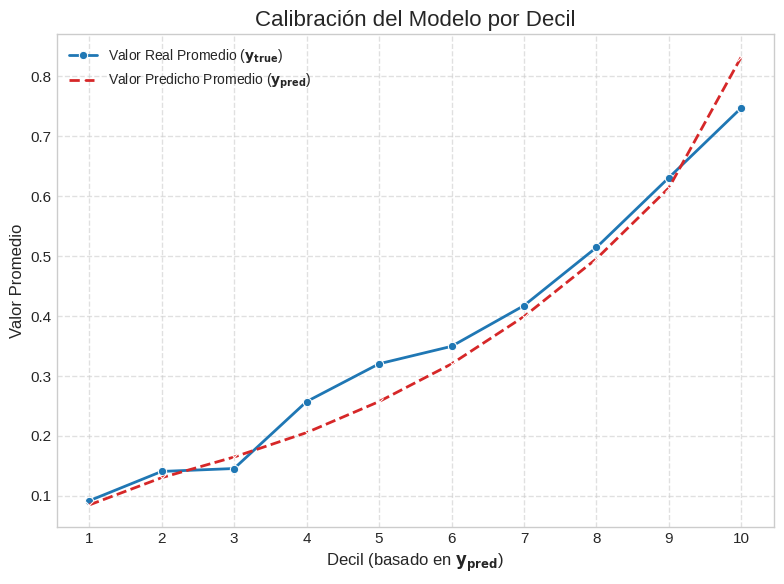

In [27]:
# Los datos proporcionados se ingresan en un DataFrame de pandas
df = pd.DataFrame(calib)
df['decil_idx'] = range(1, len(df) + 1) # Crear un índice numérico para el eje X

# ----------------------------------------------------------------------

#Comparación de y_true vs y_pred por Decil (Calibración y Discriminación)

plt.figure(figsize=(8, 6))
sns.lineplot(x='decil_idx', y='y_true', data=df, marker='o', label=r'Valor Real Promedio ($\mathbf{y_{true}}$)', color='tab:blue', linewidth=2)
sns.lineplot(x='decil_idx', y='y_pred', data=df, marker='x', label=r'Valor Predicho Promedio ($\mathbf{y_{pred}}$)', color='tab:red', linestyle='--', linewidth=2)

plt.title('Calibración del Modelo por Decil', fontsize=16)
plt.xlabel('Decil (basado en $\mathbf{y_{pred}}$)', fontsize=12)
plt.ylabel('Valor Promedio', fontsize=12)
plt.xticks(df['decil_idx']) # Asegurar que las marcas son los números de decil
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


Ya tengo el modelo de frecuencia de mi cartera, con un valor esperado de 0,3566

hablar sobre MAE entre 0,3 y 0,6 Error aceptable en datos con conteos bajos

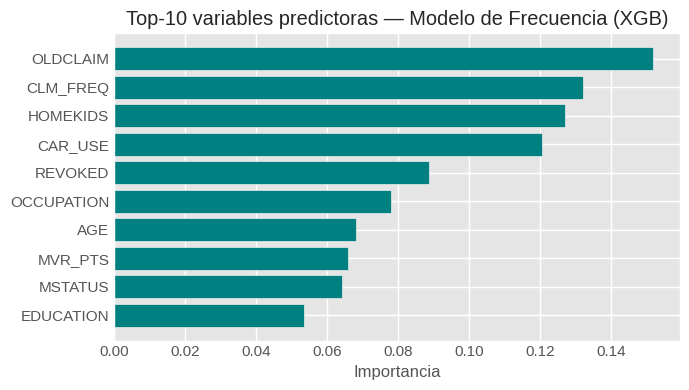

In [28]:
plt.style.use('ggplot')
cols_posibles_drop = [c for c in ['FREQUENCY','SEVERITY','ID'] if c in train_data.columns]
feat_names_freq = [c for c in train_data.columns if c not in cols_posibles_drop]

imp = getattr(model_freq, "feature_importances_", None)
if imp is None:
    print("El modelo de frecuencia no expone feature_importances_.")
else:
    # Si el modelo fue entrenado con columnas transformadas, puede no coincidir 1 a 1.
    # Tomamos el mínimo común para evitar errores.
    k = min(len(imp), len(feat_names_freq))
    pares = sorted(list(zip(feat_names_freq[:k], imp[:k])), key=lambda x: x[1], reverse=True)[:10]
    labels, vals = zip(*pares) if pares else ([], [])

    plt.figure(figsize=(7,4))
    y = np.arange(len(labels))

    # Gráfico de barras horizontales con el nuevo estilo
    plt.barh(y, vals, color='teal') # Añadí un color para mejorar la visualización

    plt.yticks(y, labels)
    plt.gca().invert_yaxis()
    plt.xlabel("Importancia")
    plt.title("Top-10 variables predictoras — Modelo de Frecuencia (XGB)")
    plt.tight_layout()
    plt.show()

# Restablecer el estilo predeterminado después de mostrar el gráfico (opcional, pero buena práctica)
plt.style.use('default')


# MODELO DE SEVERIDAD

In [29]:
df_final['SEVERITY'].max()

123247.0

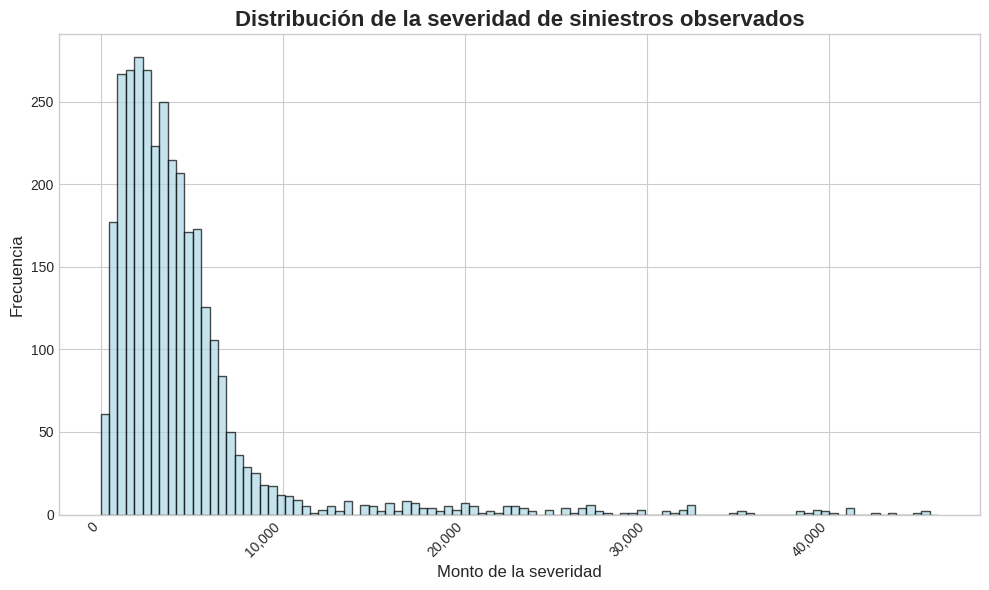

In [30]:
# Al graficar mis datos, vemos que la severidad toma la forma de una curva continua y sesgada a la derecha, lo que la hace compatible con una distribucion Gamma.
#df_final[df_final['SEVERITY'] != 0]['SEVERITY'].hist(bins = 100, range=(0, 46000))

plt.style.use('seaborn-v0_8-whitegrid')


plt.figure(figsize=(10, 6))


plt.hist(
    df_final[df_final['SEVERITY'] != 0]['SEVERITY'],
    bins=100,
    range=(0, 46000),
    color='lightblue',
    edgecolor='black',
    alpha=0.7
)

formatter = ticker.StrMethodFormatter('{x:,.0f}') # Formato con separadores de miles y cero decimales
plt.gca().xaxis.set_major_formatter(formatter)

plt.title(
    'Distribución de la severidad de siniestros observados',
    fontsize=16,
    fontweight='bold'
)
plt.xlabel('Monto de la severidad', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Rotar las etiquetas del eje X para mejor lectura de números grandes
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [31]:
def preprocess_for_sev(train_data, test_data):
    # Filtro ceros (solo positivos para severidad)
    train_nonzero = train_data[train_data['SEVERITY'] > 0].copy()
    test_nonzero  = test_data[test_data['SEVERITY'] > 0].copy()

    #  X / y
    X_train = train_nonzero.drop(['FREQUENCY', 'ID', 'SEVERITY'], axis=1)
    y_train = train_nonzero['SEVERITY']

    X_test  = test_nonzero.drop(['FREQUENCY', 'ID', 'SEVERITY'], axis=1)
    y_test  = test_nonzero['SEVERITY']

    # Categóricas vs numéricas (ya venían imputadas)
    cat_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()
    num_cols = [c for c in X_train.columns if c not in cat_cols]

    # Target Encoding SOLO en categóricas
    if len(cat_cols) > 0:
        encoder = TargetEncoder(
            cols=cat_cols, smoothing=10, min_samples_leaf=50,
            handle_unknown='value', handle_missing='value'
        )
        X_train_cat = encoder.fit_transform(X_train[cat_cols], y_train)
        X_test_cat  = encoder.transform(X_test[cat_cols])   # <- sin y_test
    else:
        X_train_cat = X_train[[]].copy()
        X_test_cat  = X_test[[]].copy()

    # matrices finales
    X_train_enc = pd.concat([X_train[num_cols].reset_index(drop=True),
                             X_train_cat.reset_index(drop=True)], axis=1)
    X_test_enc  = pd.concat([X_test[num_cols].reset_index(drop=True),
                             X_test_cat.reset_index(drop=True)], axis=1)

    return X_train_enc, X_test_enc, y_train, y_test


In [32]:
def train_test_sev(model, train_data, test_data):
    X_train, X_test, y_train, y_test = preprocess_for_sev(train_data, test_data)

    print('--- Validación de la División (y) ---')
    print(f'Media y_train: {y_train.mean():.2f}')
    print(f'Media y_test:  {y_test.mean():.2f}')
    print('------------------------------------')

    model_fit = model.fit(X_train, y_train)
    y_pred = model_fit.predict(X_test)

    # Sesgo media
    bias = (1 - y_test.mean() / y_pred.mean())
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Métricas ROBUSTAS (recortadas 99º pto para que no dominen 1-2 outliers)
    p99_y, p99_p = np.percentile(y_test, 99), np.percentile(y_pred, 99)
    mask = (y_test <= p99_y) & (y_pred <= p99_p)
    rmse_rob = np.sqrt(mean_squared_error(y_test[mask], y_pred[mask]))
    mae_rob  = mean_absolute_error(y_test[mask], y_pred[mask])

    print(f'Sesgo media: {bias:.4f}')
    print(f'RMSE: {rmse:,.2f} | MAE: {mae:,.2f}')
    print(f'RMSE(≤P99): {rmse_rob:,.2f} | MAE(≤P99): {mae_rob:,.2f}')
    print(f'R²: {r2:.4f}')

    return model_fit, y_pred, y_test, X_test


In [33]:
xgb_sev_params = {
    'objective': 'reg:gamma',     # target severidad sigue una distribución Gamma condicional a las covariables 𝑋.
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 600,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1.0,
    'alpha': 30,
    'random_state': 42
}
xgb_sev_model = create_xgb_model(xgb_sev_params)
model_sev, preds_sev, y_test_sev, X_test_sev = train_test_sev(xgb_sev_model, train_data, test_data)
print('--- Valor esperado real de la severidad de una póliza ---')
print(f'Media REAL: {df_final[df_final['SEVERITY'] != 0]['SEVERITY'].mean():.6f}')


--- Validación de la División (y) ---
Media y_train: 4797.21
Media y_test:  4649.79
------------------------------------
Sesgo media: -0.0090
RMSE: 6,662.11 | MAE: 3,044.38
RMSE(≤P99): 4,012.88 | MAE(≤P99): 2,594.05
R²: 0.0017
--- Valor esperado real de la severidad de una póliza ---
Media REAL: 4767.013778


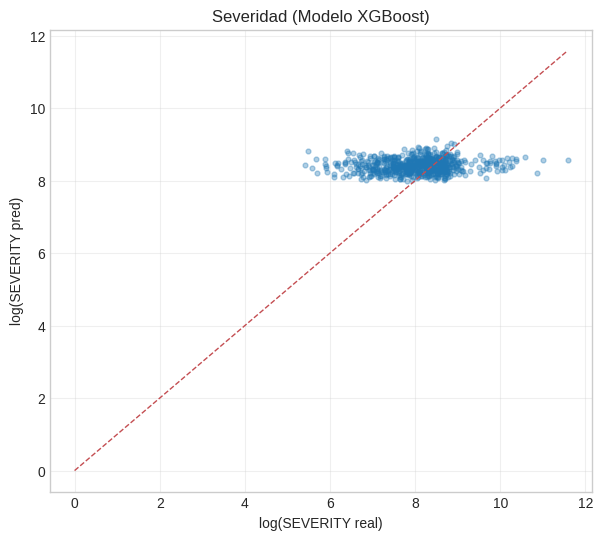

In [34]:
eps = 1e-6
plt.figure(figsize=(7,6))
plt.scatter(np.log(y_test_sev+eps), np.log(preds_sev+eps), alpha=0.35, s=12)
mx = max(np.log(y_test_sev+eps).max(), np.log(preds_sev+eps).max())
plt.plot([0, mx],[0, mx],'r--',lw=1)
plt.xlabel("log(SEVERITY real)")
plt.ylabel("log(SEVERITY pred)")
plt.title("Severidad (Modelo XGBoost)")
plt.grid(alpha=0.3)
plt.show()

Este gráfico nos muestra que el modelo describe bien el “promedio” del comportamiento, pero pierde capacidad de ajuste en los siniestros de alto valor.

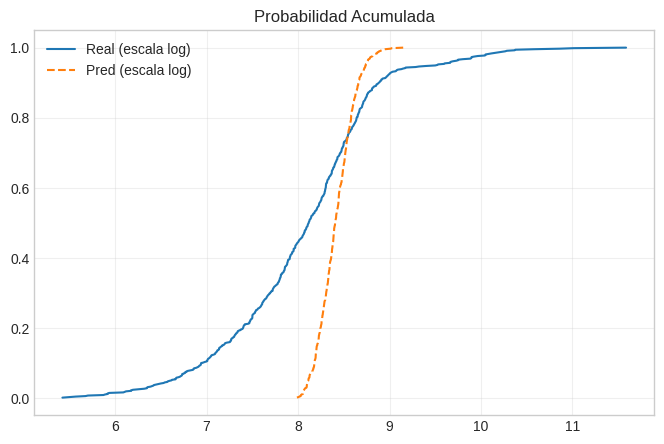

In [35]:
# "Empirical Cumulative Distribution Function" - gráfico de probabilidad acumulada (a escala logarítmica)
def ecdf(a):
    a = np.sort(a)
    return a, np.arange(1, a.size+1)/a.size

x_y, F_y = ecdf(np.log(y_test_sev+eps))
x_p, F_p = ecdf(np.log(preds_sev+eps))
plt.figure(figsize=(8,5))
plt.plot(x_y, F_y, label='Real (escala log)')
plt.plot(x_p, F_p, '--', label='Pred (escala log)')
plt.title("Probabilidad Acumulada")
plt.legend(); plt.grid(alpha=0.3); plt.show()

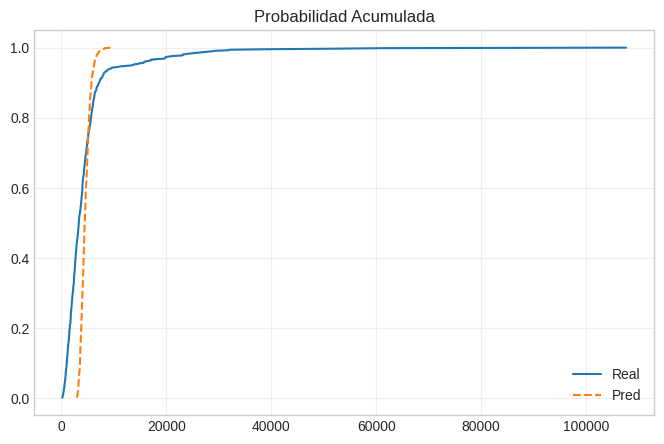

In [36]:
# "Empirical Cumulative Distribution Function" - gráfico de probabilidad acumulada
def ecdf(a):
    a = np.sort(a)
    return a, np.arange(1, a.size+1)/a.size

x_y, F_y = ecdf(y_test_sev+eps)
x_p, F_p = ecdf(preds_sev+eps)
plt.figure(figsize=(8,5))
plt.plot(x_y, F_y, label='Real')
plt.plot(x_p, F_p, '--', label='Pred')
plt.title("Probabilidad Acumulada")
plt.legend(); plt.grid(alpha=0.3); plt.show()

Se puede observar que mirando la distribución acumulada real vs. predicha, el modelo capta correctamente la forma general de la distribución, pero no reproduce adecuadamente la variabilidad y la dispersión de los valores que se encuentran en los extremos.

In [37]:
print(f"Predicción Mínima del modelo XGBOOST: {preds_sev.min():.2f}")
print(f"Predicción Máxima del modelo XGBOOST: {preds_sev.max():.2f}")
print(f"Valor máximo real: {df_final['SEVERITY'].max():.2f}")

Predicción Mínima del modelo XGBOOST: 2945.84
Predicción Máxima del modelo XGBOOST: 9407.77
Valor máximo real: 123247.00


In [38]:
VaR_dict = {}
TVaR_dict = {}
for p in [0.95, 0.99, 0.995]:
    VaR_p = np.percentile(preds_sev, 100 * p)
    TVaR_p = preds_sev[preds_sev >= VaR_p].mean()
    VaR_dict[p] = VaR_p
    TVaR_dict[p] = TVaR_p
print(f"Medidas de riesgo del modelo XGBOOST:")
for p in [0.95, 0.99, 0.995]:

    print(f"{int(p*100)}%")
    print(f"  VaR = {VaR_dict[p]:.2f}")
    print(f"  TVaR = {TVaR_dict[p]:.2f}\n")


Medidas de riesgo del modelo XGBOOST:
95%
  VaR = 6250.62
  TVaR = 6905.61

99%
  VaR = 7271.92
  TVaR = 7990.50

99%
  VaR = 7648.34
  TVaR = 8410.23



---------------------------------------------------------------------------

## **Modelo MIXTO: Machine Learning y Teoría de Valores Extremos**

---------------------------------------------------------------------------

## 🎯 SELECCIÓN DEL THRESHOLD



**Mean Excess Plot**

e(u)=E[X−u/X>u]

Si los datos en la cola realmente siguen una Generalized Pareto Distribution (GPD), el gráfico de e(u) en función de u debería verse aproximadamente lineal a partir de cierto punto.

Ese “punto de quiebre” (cuando pasa de curvado a casi lineal) es el umbral candidato.

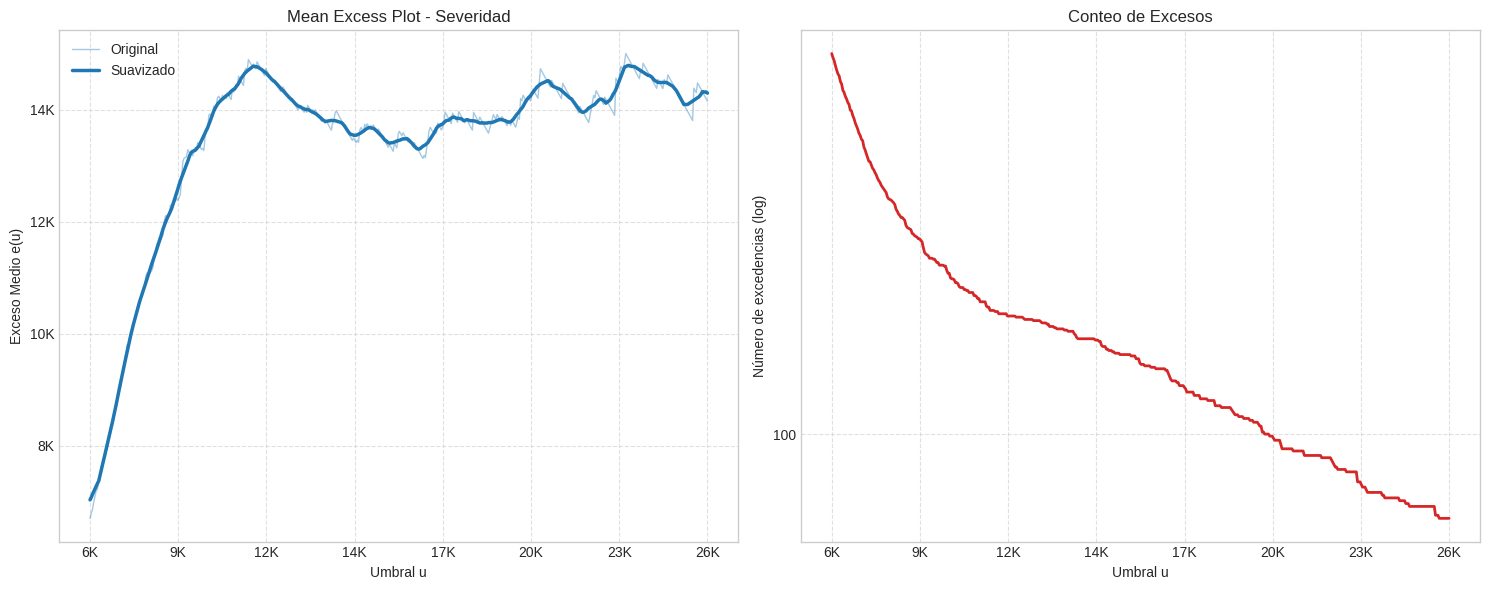

In [39]:
from matplotlib.ticker import FuncFormatter, LogLocator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def human_format(x, pos=None):
    if x >= 1e6: return f"{x/1e6:.1f}M"
    if x >= 1e3: return f"{x/1e3:.0f}K"
    return f"{x:.0f}"

# Datos
claims = df_final.loc[df_final['SEVERITY'] > 0, 'SEVERITY'].to_numpy()
claims = claims[np.isfinite(claims)]

def mean_excess_and_count(data, thresholds):
    mean_excesses, num_exceedances = [], []
    for u in thresholds:
        exc = data[data > u] - u
        num_exceedances.append(exc.size)
        mean_excesses.append(np.nan if exc.size == 0 else exc.mean())
    return mean_excesses, num_exceedances

# Umbrales
start_threshold = np.percentile(claims, 80)
end_threshold   = np.percentile(claims, 98)
thresholds = np.linspace(start_threshold, end_threshold, 500)

e_values, n_exceedances = mean_excess_and_count(claims, thresholds)

# --- Suavizado (media móvil) ---
window = 15  # cantidad de puntos del promedio móvil
e_smooth = pd.Series(e_values).rolling(window, center=True, min_periods=1).mean()

# --- Gráfico ---
fmt = FuncFormatter(human_format)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
xticks = np.linspace(start_threshold, end_threshold, 8)

# Mean Excess Plot (suavizado)
ax1.plot(thresholds, e_values, lw=1, alpha=0.4, color="tab:blue", label="Original")
ax1.plot(thresholds, e_smooth, lw=2.5, color="tab:blue", label="Suavizado")
ax1.set_xlabel("Umbral u"); ax1.set_ylabel("Exceso Medio e(u)")
ax1.set_title("Mean Excess Plot - Severidad")
ax1.grid(True, ls="--", alpha=0.6)
ax1.legend()
ax1.set_xticks(xticks)
ax1.xaxis.set_major_formatter(fmt)
ax1.yaxis.set_major_formatter(fmt)

# Conteo de excedencias
ax2.plot(thresholds, n_exceedances, lw=2, color="tab:red")
ax2.set_xlabel("Umbral u"); ax2.set_ylabel("Número de excedencias (log)")
ax2.set_title("Conteo de Excesos")
ax2.grid(True, ls="--", alpha=0.6)
ax2.set_yscale("log")
ax2.set_xticks(xticks)
ax2.xaxis.set_major_formatter(fmt)
ax2.yaxis.set_major_locator(LogLocator(base=10))
ax2.yaxis.set_major_formatter(fmt)

plt.tight_layout()
plt.show()


 👉 Antes del valor 10,000: *la curva es cóncava y con pendiente creciente pronunciada* → esa zona todavía pertenece al cuerpo de la distribución, no a la cola “pura”. -->

🎯 A partir de ≈ 10,000 - 11,000: **PUNTO DE QUIEBRE**. La pendiente comienza a estabilizarse y el crecimiento del exceso medio se vuelve casi lineal, aunque con pequeñas fluctuaciones debidas a la menor cantidad de observaciones.


El gráfico se aplaca y muestra fluctuaciones aleatorias y planas (una tendencia constante, alrededor de 14K)


Este es el rango de umbral óptimo para aplicar la GPD. Indica que, para cualquier umbral u que elijas en esta zona (p. ej., $11K, $15K, $17K), la media del exceso sobre ese umbral permanece esencialmente constante (o ligeramente creciente).

*Basado en el gráfico, un umbral de alrededor de $11,000 sería un buen punto de partida.*


Este análisis es una prueba de robustez del modelo EVT.

El modelo es sensible a la elección del umbral $u$.

El umbral más bajo ($u=7500$) resulta en el mayor riesgo (VaR y TVaR) debido a que su GPD tiene el $\xi$ más alto, indicando una cola de distribución de pérdidas extremadamente pesada. Si se elige este umbral, la estimación del riesgo es la más conservadora.

Los umbrales más altos ($u =10000, u=11000$ y $u=15000$) producen estimaciones de VaR y TVaR similares entre sí, lo que sugiere que, para la población de siniestros por encima de $10000$, la distribución de pérdidas extremas es más estable y ligera.


Para la toma de decisiones (por ejemplo, determinar una reserva de capital), un actuario o gestor de riesgos probablemente favorecería el umbral que ofrece los parámetros de GPD más estables, mientras que también consideraría el nivel de conservación deseado.

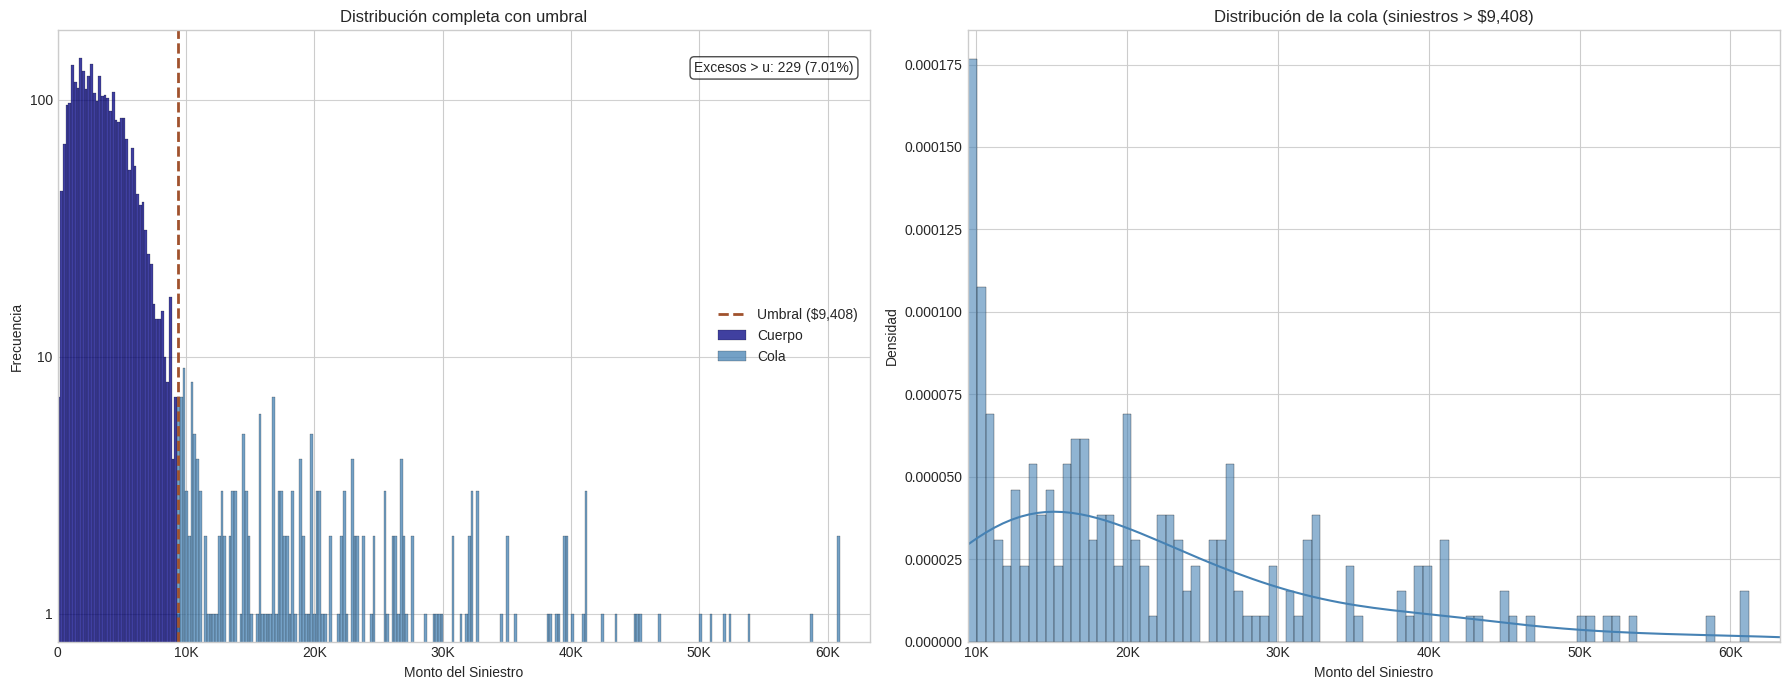

In [40]:
# --- UMBRAL ---
threshold = 9407.77
# --- SEPARACIÓN CUERPO / COLA ---
body_claims = claims[claims <= threshold]
tail_claims = claims[claims > threshold]
#--- Stats útiles para el informe
n_total = claims.size
n_tail  = tail_claims.size
pct_tail = 100 * n_tail / max(n_total, 1)
# ---------------------------------------------
# GRÁFICOS
# ---------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot 1: Distribución completa con umbral ---
bins_full = np.linspace(0, np.percentile(claims, 99.9), 300)  # ajustado al rango real de tus datos

sns.histplot(body_claims, bins=bins_full, kde=False, color='navy', label='Cuerpo', ax=ax1)
sns.histplot(tail_claims, bins=bins_full, kde=False, color='steelblue', label='Cola', ax=ax1)

ax1.axvline(x=threshold, color='sienna', linestyle='--', linewidth=2, label=f'Umbral (${threshold:,.0f})')
ax1.set_xlabel('Monto del Siniestro')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución completa con umbral')
ax1.set_yscale('log')  # útil para ver la cola
ax1.grid(axis='y', alpha=0.9)
ax1.legend()
ax1.xaxis.set_major_formatter(FuncFormatter(human_format))
ax1.yaxis.set_major_formatter(FuncFormatter(human_format))
ax1.set_xlim(0, np.percentile(claims, 99.9))
# Nota en el gráfico con #excesos
ax1.text(0.98, 0.95, f'Excesos > u: {n_tail} ({pct_tail:.2f}%)',
         transform=ax1.transAxes, ha='right', va='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
# --- Plot 2: Vista ampliada de la cola ---
sns.histplot(tail_claims, bins=200, kde=True, color='steelblue', ax=ax2, stat='density', alpha=0.6)
ax2.set_xlabel('Monto del Siniestro')
ax2.set_ylabel('Densidad')
ax2.set_title(f'Distribución de la cola (siniestros > ${threshold:,.0f})')
ax2.grid(axis='y', alpha=0.9)
ax2.xaxis.set_major_formatter(FuncFormatter(human_format))
ax2.set_xlim(threshold, np.percentile(claims, 99.9))

plt.tight_layout()
plt.show()

✅*Ajusto la distribución de los valores extremos vía PEAKS OVER THRESHOLD*

In [41]:
from scipy.stats import genpareto

def fit_gpd_excesses(x, u):
    # Excesos (X > u)
    y = np.asarray(x)[x > u] - u
    # fijo loc=0
    xi, loc, beta = genpareto.fit(y, floc=0.0) #GPD ajustada debe empezar en 0 (el exceso mínimo).
    return xi, beta, y

def var_pot(p, xi, beta, u, p_u):
    # válido SOLO si p > 1 - p_u (cuantil en la cola) --- recordar que solo podemos conocer el VaR si el percentil está dentro de la cola de dist.
    if p <= 1 - p_u:
        return np.nan
    if abs(xi) < 1e-8:  # límite xi→0
        return u + beta * np.log(p_u/(1-p))
    return u + (beta/xi) * ((p_u/(1-p))**xi - 1)

def tvar_pot(p, xi, beta, u, p_u):
    v = var_pot(p, xi, beta, u, p_u)
    if np.isnan(v):
        return np.nan
    if xi >= 1:
        return np.inf
    return u + (beta + (v - u)) / (1 - xi)

u = threshold
claims = df_final.loc[df_final["SEVERITY"] > 0, "SEVERITY"].to_numpy()
xi, beta, excesses = fit_gpd_excesses(claims, u)
p_u = (claims > u).mean()

print(f"xi={xi:.4f}, beta={beta:.2f}, p_u={p_u:.4f}")

for p in [0.95, 0.99, 0.995]:
    v = var_pot(p, xi, beta, u, p_u)
    es = tvar_pot(p, xi, beta, u, p_u)
    label = f"{int(p*1000)/10:.1f}%"
    print(f"\nNivel {label}")
    if np.isnan(v):
        print("  (El cuantíl está por debajo del umbral: usar el modelo del cuerpo / empírico)")
    else:
        print(f"  VaR  = {v:,.2f}")
        print(f"  TVaR = {es:,.2f}   (Δ={es - v:,.2f} ≥ 0)")


xi=0.1073, beta=11896.06, p_u=0.0701

Nivel 95.0%
  VaR  = 13,504.06
  TVaR = 27,321.73   (Δ=13,817.67 ≥ 0)

Nivel 99.0%
  VaR  = 35,174.00
  TVaR = 51,595.48   (Δ=16,421.48 ≥ 0)

Nivel 99.5%
  VaR  = 45,722.82
  TVaR = 63,411.83   (Δ=17,689.00 ≥ 0)


In [42]:
candidates = [7500,10000, 11000, 15000]
rows = []
claims = df_final.loc[df_final["SEVERITY"]>0, "SEVERITY"].to_numpy()

for u_ in candidates:
    xi_, beta_, exc_ = fit_gpd_excesses(claims, u_)
    p_u_ = (claims > u_).mean()
    for p in [0.99, 0.995]:
        VaR_ = var_pot(p, xi_, beta_, u_, p_u_)
        TVaR_ = tvar_pot(p, xi_, beta_, u_, p_u_)
        rows.append({"u": u_, "p": p, "xi": xi_, "beta": beta_, "p_u": p_u_, "VaR": VaR_, "TVaR": TVaR_})
sens = pd.DataFrame(rows)
print(sens)

       u      p        xi          beta       p_u           VaR          TVaR
0   7500  0.990  0.428564   6678.722344  0.101347  33962.795214  65496.903165
1   7500  0.995  0.428564   6678.722344  0.101347  48506.483394  90948.027229
2  10000  0.990  0.050960  13465.503048  0.063074  36000.818600  51585.524697
3  10000  0.995  0.050960  13465.503048  0.063074  46436.033140  62581.073657
4  11000  0.990  0.020782  14517.630995  0.056338  36554.157873  51922.232538
5  11000  0.995  0.020782  14517.630995  0.056338  47060.609954  62651.663076
6  15000  0.990  0.102419  12267.721465  0.045928  35241.017875  51218.158878
7  15000  0.995  0.102419  12267.721465  0.045928  45542.626434  62695.235598


👉 La brecha TVaR−VaR ~ 15K es bastante estable entre 99% y 99.5% → señal de cola “no explosiva”.

👉 ξ ≈ 0.021 > 0 pero pequeño → cola ligera (más pesada que exponencial, mucho más liviana que Pareto “dura”).


👉 El ajuste POT–GPD con 𝑢=11,000 captura una cola moderadamente pesada y produce VaR/TVaR razonables y crecientes. Esto valida la necesidad del enfoque mixto: el ML “puro” comprimía la cola; la GPD corrige esa subestimación.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7524 (\N{LATIN SUBSCRIPT SMALL LETTER U}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


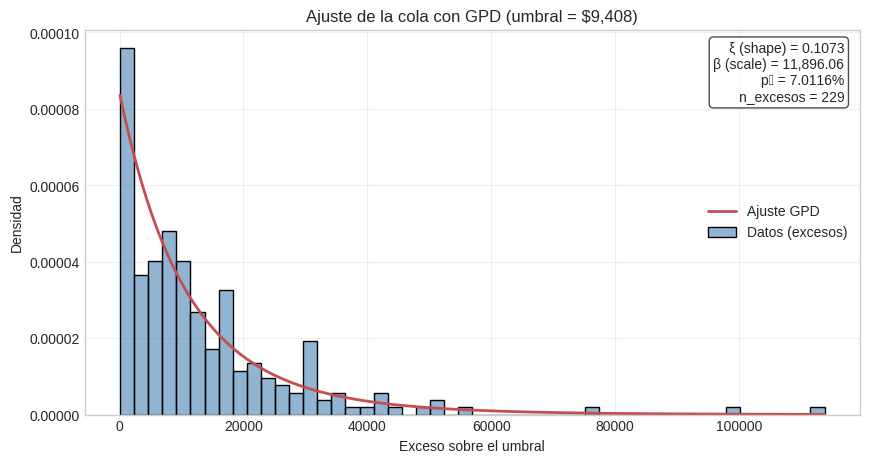

In [43]:
# --- Visualización del ajuste GPD ---
x = np.linspace(excesses.min(), excesses.max(), 200)
pdf_gpd = genpareto.pdf(x, xi, loc=0, scale=beta)  # loc=0 para excesos

plt.figure(figsize=(10, 5))
sns.histplot(
    excesses, bins=50, stat='density', color='steelblue', alpha=0.6, label='Datos (excesos)'
)
plt.plot(x, pdf_gpd, 'r-', lw=2, label='Ajuste GPD')

# --- Título y ejes ---
plt.title(f"Ajuste de la cola con GPD (umbral = ${threshold:,.0f})")
plt.xlabel('Exceso sobre el umbral')
plt.ylabel('Densidad')
plt.legend()
plt.grid(alpha=0.3)

# --- Texto con parámetros ---
param_text = (
    f"ξ (shape) = {xi:.4f}\n"
    f"β (scale) = {beta:,.2f}\n"
    f"pᵤ = {p_u:.4%}\n"
    f"n_excesos = {len(excesses)}"
)
plt.text(
    0.98, 0.97, param_text,
    transform=plt.gca().transAxes,
    ha='right', va='top',
    fontsize=10,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)

plt.show()

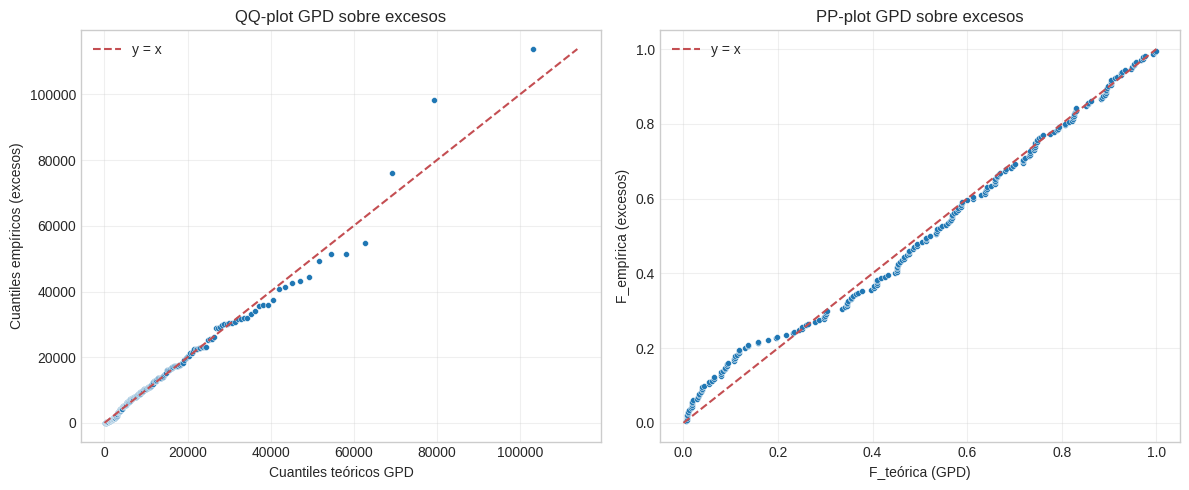

KS statistic: 0.0785  |  p-value: 0.1126


In [44]:
from scipy.stats import kstest

# === QQ-PLOT (excesos empíricos vs cuantiles teóricos GPD) ===
ex = np.asarray(excesses)
ex_sorted = np.sort(ex)
n = len(ex_sorted)

# Probabilidades "de gráfico" (evitan 0 y 1): (i - 0.5)/n
p = (np.arange(1, n+1) - 0.5) / n

# Cuantiles teóricos bajo GPD ajustada (loc=0 porque son excesos)
q_theo = genpareto.ppf(p, c=xi, scale=beta, loc=0.0)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=q_theo, y=ex_sorted, s=18)
mx = max(q_theo.max(), ex_sorted.max())
plt.plot([0, mx], [0, mx], 'r--', lw=1.5, label='y = x')
plt.xlabel('Cuantiles teóricos GPD')
plt.ylabel('Cuantiles empíricos (excesos)')
plt.title('QQ-plot GPD sobre excesos')
plt.grid(alpha=0.3)
plt.legend()

# (Opcional) versión log-log para resaltar cola
# plt.xscale('log'); plt.yscale('log')

# === PP-PLOT (CDF teórica vs CDF empírica) ===
F_theo = genpareto.cdf(ex_sorted, c=xi, scale=beta, loc=0.0)
F_emp  = np.arange(1, n+1) / (n+1)  # escalado clásico

plt.subplot(1,2,2)
sns.scatterplot(x=F_theo, y=F_emp, s=18)
plt.plot([0,1], [0,1], 'r--', lw=1.5, label='y = x')
plt.xlabel('F_teórica (GPD)')
plt.ylabel('F_empírica (excesos)')
plt.title('PP-plot GPD sobre excesos')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# === KS test (goodness-of-fit) sobre excesos ===
# H0: los excesos provienen de GPD(xi, beta)
ks_stat, ks_p = kstest(ex, lambda z: genpareto.cdf(z, c=xi, scale=beta, loc=0.0))
print(f"KS statistic: {ks_stat:.4f}  |  p-value: {ks_p:.4f}")


p-value = 0.4864 → indica que no hay evidencia estadísticamente significativa para rechazar la hipótesis nula
(“los excesos provienen de una distribución GPD con tus parámetros estimados”).

In [45]:
# --- Empírico (XGB “puro”) sobre observados positivos ---
sev_pos = np.asarray(y_test_sev)[np.asarray(y_test_sev) > 0]
sev_pos.sort()

def var_empirico(arr, p):
    if len(arr) == 0: return np.nan
    return float(np.quantile(arr, p, interpolation="linear"))

def tvar_empirico(arr, p):
    if len(arr) == 0: return np.nan
    v = var_empirico(arr, p)
    exc = arr[arr >= v]
    if len(exc) == 0: return v
    return float(exc.mean())

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

ps = [0.99, 0.995, 0.999]
rows = []
for p in ps:
    var_xgb = var_empirico(sev_pos, p)
    tvar_xgb = tvar_empirico(sev_pos, p)

    if p <= 1 - p_u:
        # nivel de cola aún no alcanzado: usar empírico (híbrido==xgb)
        var_h  = var_xgb
        tvar_h = tvar_xgb
    else:
        var_h  = var_pot(p, xi, beta, u, p_u)
        tvar_h = tvar_pot(p, xi, beta, u, p_u)

    rows.append({
        "p": p,
        "VaR_XGB": var_xgb,
        "VaR_Híbrido": var_h,
        "Δ_VaR_%": 100.0 * (var_h - var_xgb) / var_xgb if np.isfinite(var_xgb) and var_xgb>0 else np.nan,
        "TVaR_XGB": tvar_xgb,
        "TVaR_Híbrido": tvar_h,
        "Δ_TVaR_%": 100.0 * (tvar_h - tvar_xgb) / tvar_xgb if np.isfinite(tvar_xgb) and tvar_xgb>0 else np.nan
    })

tabla_var = pd.DataFrame(rows)
print(tabla_var)


       p    VaR_XGB   VaR_Híbrido    Δ_VaR_%       TVaR_XGB  TVaR_Híbrido  \
0  0.990  28872.720  35173.998594  21.824333   50436.571429  51595.477144   
1  0.995  36921.340  45722.823286  23.838472   64983.250000  63411.825766   
2  0.999  76364.348  73464.094021  -3.797916  107586.000000  94486.427513   

    Δ_TVaR_%  
0   2.297749  
1  -2.418199  
2 -12.175908  


/tmp/ipython-input-1899663306.py:21: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  var_xgb = var_empirico(sev_pos, p)
/tmp/ipython-input-1899663306.py:11: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  v = var_empirico(arr, p)


In [46]:
def preprocess_for_body(train_data, test_data, u):
    # Filtrar SOLO cuerpo: 0 < SEVERITY ≤ u
    tr = train_data
    te = test_data

    X_train = tr.drop(['FREQUENCY','ID','SEVERITY'], axis=1)
    y_train = tr['SEVERITY']

    X_test  = te.drop(['FREQUENCY','ID','SEVERITY'], axis=1)
    y_test  = te['SEVERITY']

    # Categóricas encode
    cat_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()
    num_cols = [c for c in X_train.columns if c not in cat_cols]

    if len(cat_cols) > 0:
        enc = TargetEncoder(
            cols=cat_cols, smoothing=10, min_samples_leaf=50,
            handle_unknown='value', handle_missing='value'
        )
        X_train_cat = enc.fit_transform(X_train[cat_cols], y_train)
        X_test_cat  = enc.transform(X_test[cat_cols])
    else:
        enc = None
        X_train_cat = X_train[[]].copy()
        X_test_cat  = X_test[[]].copy()

    Xtr = pd.concat([X_train[num_cols].reset_index(drop=True),
                     X_train_cat.reset_index(drop=True)], axis=1)
    Xte = pd.concat([X_test[num_cols].reset_index(drop=True),
                     X_test_cat.reset_index(drop=True)], axis=1)

    # target en log
    ytr_log = np.log(y_train.values)
    yte      = y_test.values  # guardamos en escala original

    return Xtr, Xte, ytr_log, yte, enc, cat_cols, num_cols



In [47]:
def train_test_body(model, train_data, test_data, u):
    Xtr, Xte, ytr_log, yte, enc, cat_cols, num_cols = preprocess_for_body(train_data, test_data, u)

    # dentro de train_test_body, después de crear Xtr, ytr_log
    ytr = np.minimum(np.exp(ytr_log), u)  # escala original, truncado en u por definición del cuerpo
    # k controla cuánto “empujás” la zona alta (3–6 suele andar bien)
    k = 4
    w = (ytr / u) ** k           # en [0,1]; cerca de u → peso alto
    w = np.clip(w, 0.1, 10.0)    # límites sanos para estabilidad
    model_fit = model.fit(Xtr, ytr_log, sample_weight=w)
    ypred_log = model_fit.predict(Xte)

    # Corrección de back-transform (lognormal): E[Y] ≈ exp(mu + 0.5*sigma^2)
    res = ytr_log - model_fit.predict(Xtr)
    sigma2 = float(np.mean(res**2)) #varianza
    corr = float(np.exp(0.5 * sigma2)) #factor de corrección del sesgo lognormal - corrige el sesgo introducido al volver de log a escala original.

    ypred = np.exp(ypred_log) * corr
    # eso hace que si el modelo del cuerpo predice un valor mayor al umbral, recórtalo (‘clip’) justo por debajo de u

    # >>> métricas <<<
    rmse = float(np.sqrt(mean_squared_error(yte, ypred)))
    mae  = float(mean_absolute_error(yte, ypred))
    bias = float((np.mean(ypred) - np.mean(yte)) / max(np.mean(yte), 1e-12))

    print(f"Cuerpo (≤ u={u:,}) — RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | Bias: {100*bias:.2f}%")
    print(f"Var(log-residuos)≈{sigma2:.4f}  ⇒  factor de corrección exp(0.5σ²)={corr:.4f}")

    return model_fit, enc, cat_cols, num_cols, ypred, yte



In [48]:
 # Filtrar SOLO cuerpo: 0 < SEVERITY ≤ u
body_train = train_data[(train_data['SEVERITY'] > 0)].copy()
body_test  = test_data[(test_data['SEVERITY'] > 0)].copy()
xgb_body_params = {
    'objective': 'reg:gamma',
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 600,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1.0,
    'random_state': 42
}
xgb_body_model = create_xgb_model(xgb_body_params)

# Entreno con splits body_train / body_test y el umbral elegido
model_body, enc_body, cat_cols_body, num_cols_body, preds_body, y_test_body = (
    train_test_body(xgb_body_model, body_train, body_test, u)
)
preds_body = preds_body[preds_body <= u]
preds_body.max()


Cuerpo (≤ u=9,407.77) — RMSE: 7,327.04 | MAE: 3,683.19 | Bias: 5.90%
Var(log-residuos)≈0.2913  ⇒  factor de corrección exp(0.5σ²)=1.1568


np.float32(9379.742)

In [49]:
simulated_excesses = genpareto.rvs(
    c=xi,               # 'c' es el parámetro de forma xi en scipy
    loc=0.0,            # El exceso mínimo es 0
    scale=beta,
    size= 230,
    random_state=8

)
simulated_tail_claims = simulated_excesses + u

print(f"\nPredicción Mínima de la Cola vía Peaks Over Threshold: {np.min(simulated_tail_claims):,.2f}")
print(f"Predicción Máxima de la Cola vía Peaks Over Threshold: {np.max(simulated_tail_claims):,.2f}")

print(f"Predicción Mínima del modelo XGBOOST: {preds_body.min():.2f}")
print(f"Predicción Máxima del modelo XGBOOST: {preds_body.max():.2f}")
print(f"Valor máximo real: {df_final['SEVERITY'].max():.2f}")


Predicción Mínima de la Cola vía Peaks Over Threshold: 9,416.62
Predicción Máxima de la Cola vía Peaks Over Threshold: 106,207.95
Predicción Mínima del modelo XGBOOST: 1078.42
Predicción Máxima del modelo XGBOOST: 9379.74
Valor máximo real: 123247.00


VALOR ESPERADO DE SEVERIDAD MIXTA:

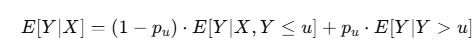

# VALOR ESPERADO DE SEVERIDAD

In [50]:
E_body = np.mean(preds_body)
print(f"valor esperado de severidad condicionado a que esté dentro del grueso de la distribución: {E_body:,.2f}")

valor esperado de severidad condicionado a que esté dentro del grueso de la distribución: 4,338.54


In [51]:
# media teórica de la cola bajo una distribución Generalized Pareto (GPD)
def tail_mean(u, xi, beta):
    if xi >= 1:
        return np.inf
    return u + beta/(1 - xi)

E_tail = tail_mean(u, xi, beta)
print(f"valor esperado de severidad condicionado a que esté dentro de la cola de la distribución: {E_tail:,.2f}")

valor esperado de severidad condicionado a que esté dentro de la cola de la distribución: 22,733.23


In [52]:
p_u

np.float64(0.07011635027556644)

In [53]:
E_X = (1 - p_u) * E_body + p_u * E_tail
print(f"valor esperado de severidad descontextualizado: {E_X:,.2f}")
print(f"valor esperado de severidad real: {df_final[df_final['SEVERITY'] != 0]['SEVERITY'].mean():,.2f}")

valor esperado de severidad descontextualizado: 5,628.31
valor esperado de severidad real: 4,767.01


# VALOR ESPERADO DE SINIESTRALIDAD (FRECUENCIA X SEVERIDAD)

In [54]:
E_S = E_X * valor_esp_frecuencia
print(f"Prima Pura -  valor esperado de siniestralidad por póliza: {E_S:,.2f}")

Prima Pura -  valor esperado de siniestralidad por póliza: 1,971.82


In [55]:
E_X

np.float64(5628.307504658313)

In [56]:
print(f"Prima Pura -  valor esperado de siniestralidad por póliza sin enfoque Peaks Over Threshold: {df_final[df_final['SEVERITY'] != 0]['SEVERITY'].mean() * valor_esp_frecuencia:,.2f}")


Prima Pura -  valor esperado de siniestralidad por póliza sin enfoque Peaks Over Threshold: 1,670.07


In [57]:
loading = E_S/(df_final[df_final['SEVERITY'] != 0]['SEVERITY'].mean() * valor_esp_frecuencia)-1
print(f"Margen - recargo que se le puede hacer a la prima para contemplar este riesgo de valor extremo: {loading:,.5f}")

Margen - recargo que se le puede hacer a la prima para contemplar este riesgo de valor extremo: 0.18068


# MEDIDAS DE RIESGO

In [58]:
print("Medidas de riesgo del modelo de distribución híbrida con enfoque Peaks Over Threshold")
for p in [0.95, 0.99, 0.995]:
    v = var_pot(p, xi, beta, u, p_u)
    es = tvar_pot(p, xi, beta, u, p_u)
    label = f"{int(p*1000)/10:.1f}%"
    print(f"\nNivel {label}")
    if np.isnan(v):
        print("  (El cuantíl está por debajo del umbral: usar el modelo del cuerpo / empírico)")
    else:
        print(f"  VaR  = {v:,.2f}")
        print(f"  TVaR = {es:,.2f}   (Δ={es - v:,.2f} ≥ 0)")

Medidas de riesgo del modelo de distribución híbrida con enfoque Peaks Over Threshold

Nivel 95.0%
  VaR  = 13,504.06
  TVaR = 27,321.73   (Δ=13,817.67 ≥ 0)

Nivel 99.0%
  VaR  = 35,174.00
  TVaR = 51,595.48   (Δ=16,421.48 ≥ 0)

Nivel 99.5%
  VaR  = 45,722.82
  TVaR = 63,411.83   (Δ=17,689.00 ≥ 0)


In [59]:
print("Medidas de riesgo del modelo de Machine Learning XGBoost puro")
VaR_dict = {}
TVaR_dict = {}
for p in [0.95, 0.99, 0.995]:
    VaR_p = np.percentile(preds_sev, 100 * p)
    TVaR_p = preds_sev[preds_sev >= VaR_p].mean()
    VaR_dict[p] = VaR_p
    TVaR_dict[p] = TVaR_p
    label = f"{int(p*1000)/10:.1f}%"
    print(f"\nNivel {label}")
    if np.isnan(v):
        print("  (El cuantíl está por debajo del umbral: usar el modelo del cuerpo / empírico)")
    else:
        print(f"  VaR  = {VaR_dict[p]:,.2f}")
        print(f"  TVaR = {TVaR_dict[p]:,.2f}")


Medidas de riesgo del modelo de Machine Learning XGBoost puro

Nivel 95.0%
  VaR  = 6,250.62
  TVaR = 6,905.61

Nivel 99.0%
  VaR  = 7,271.92
  TVaR = 7,990.50

Nivel 99.5%
  VaR  = 7,648.34
  TVaR = 8,410.23


In [60]:
u

9407.77

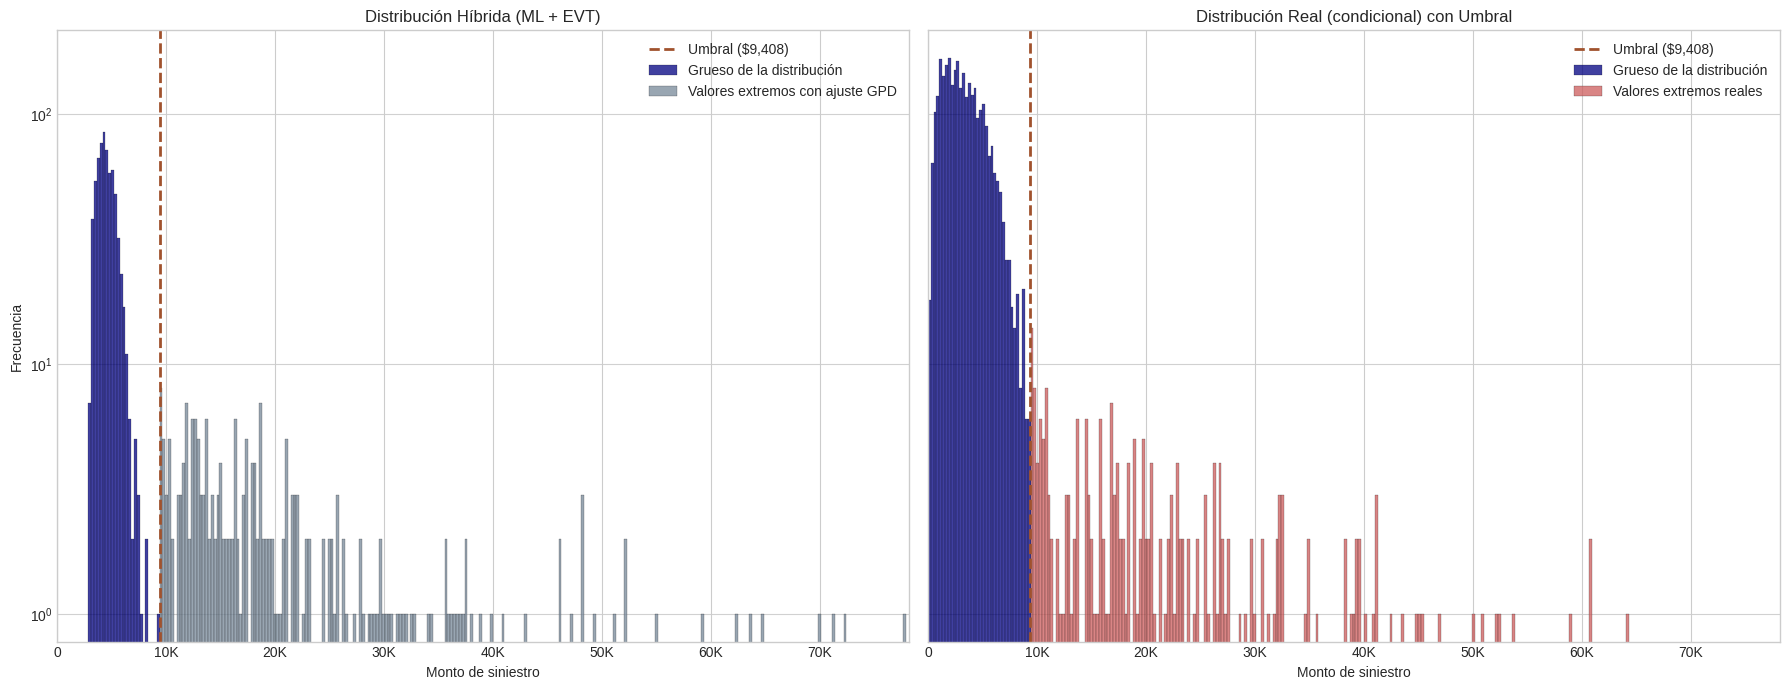

In [61]:
preds_hybrid_full = np.concatenate([preds_sev, simulated_tail_claims])


preds_body_plot = preds_hybrid_full[preds_hybrid_full  <= threshold]
preds_tail_plot = preds_hybrid_full[preds_hybrid_full >  threshold]

real_body_plot = claims[claims <= threshold]
real_tail_plot = claims[claims >  threshold]

x_max = np.percentile(np.concatenate([preds_hybrid_full, claims]), 99.9)
bins_full = np.linspace(0, x_max, 300)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# ====== Panel IZQ: HÍBRIDA (ML+EVT) ======
sns.histplot(preds_body_plot, bins=bins_full, kde=False, color='navy',
             label='Grueso de la distribución', ax=ax1)
sns.histplot(preds_tail_plot, bins=bins_full, kde=False, color='lightslategray',
             label='Valores extremos con ajuste GPD', ax=ax1)

ax1.axvline(x=threshold, color='sienna', linestyle='--', linewidth=2,
            label=f'Umbral (${threshold:,.0f})')
ax1.set_xlabel('Monto de siniestro')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución Híbrida (ML + EVT)')
ax1.set_yscale('log')
ax1.grid(axis='y', alpha=0.9)
ax1.legend()
ax1.xaxis.set_major_formatter(FuncFormatter(human_format))
ax1.yaxis.set_major_formatter(FuncFormatter(human_format))
ax1.set_xlim(0, x_max)

# ====== Panel DER: REAL (SEVERITY > 0) ======
sns.histplot(real_body_plot, bins=bins_full, kde=False, color='navy',
             label='Grueso de la distribución', ax=ax2)
sns.histplot(real_tail_plot, bins=bins_full, kde=False, color='indianred',
             label='Valores extremos reales', ax=ax2)

ax2.axvline(x=threshold, color='sienna', linestyle='--', linewidth=2,
            label=f'Umbral (${threshold:,.0f})')
ax2.set_xlabel('Monto de siniestro')
ax2.set_title('Distribución Real (condicional) con Umbral')
ax2.set_yscale('log')
ax2.grid(axis='y', alpha=0.9)
ax2.legend()
ax2.xaxis.set_major_formatter(FuncFormatter(human_format))
ax2.set_xlim(0, x_max)

plt.tight_layout()
plt.show()


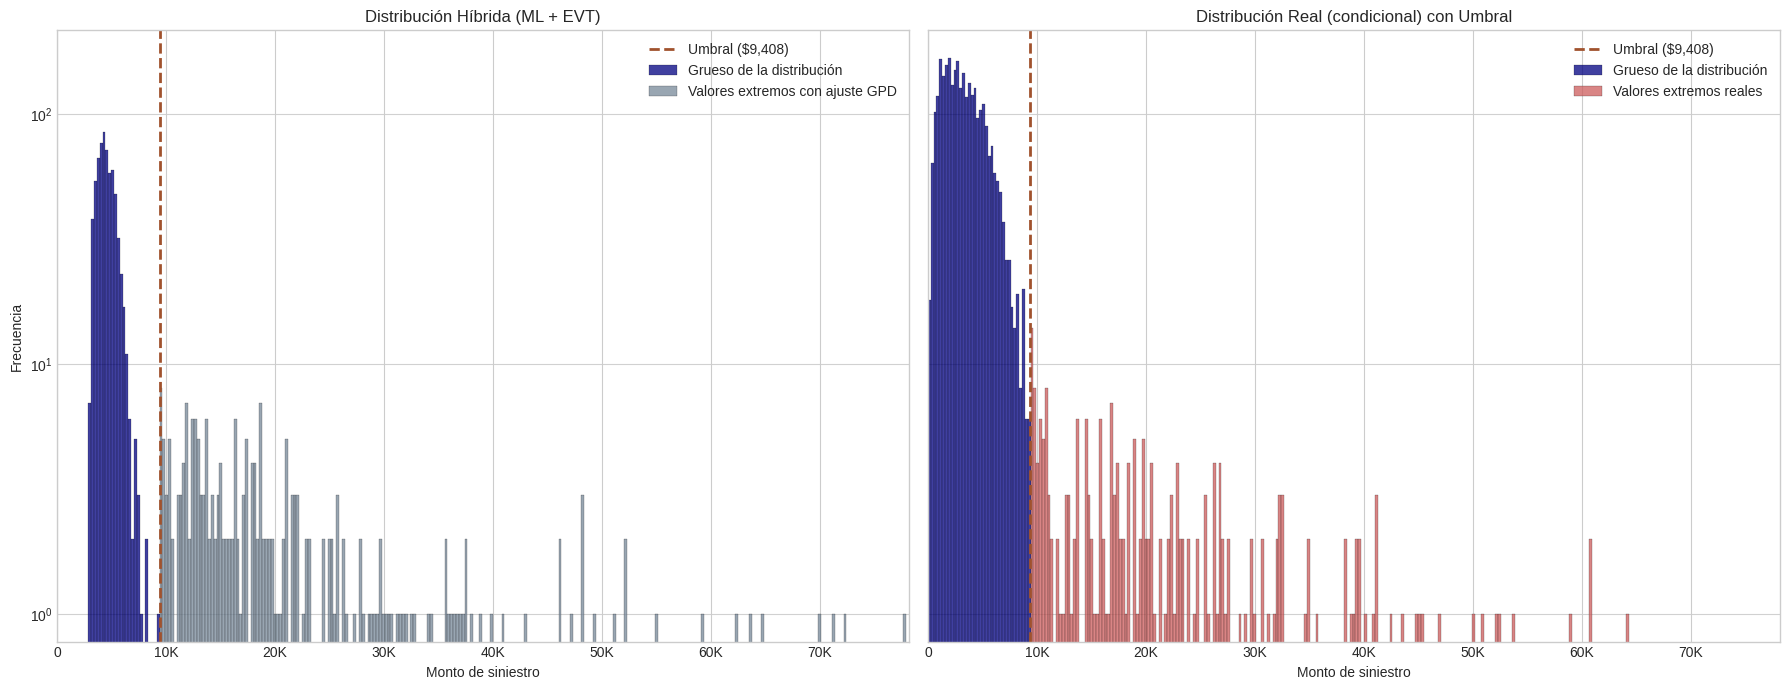

In [62]:
preds_hybrid_full = np.concatenate([preds_sev, simulated_tail_claims])


preds_body_plot = preds_hybrid_full[preds_hybrid_full  <= threshold]
preds_tail_plot = preds_hybrid_full[preds_hybrid_full >  threshold]

real_body_plot = claims[claims <= threshold]
real_tail_plot = claims[claims >  threshold]

x_max = np.percentile(np.concatenate([preds_hybrid_full, claims]), 99.9)
bins_full = np.linspace(0, x_max, 300)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# ====== Panel IZQ: HÍBRIDA (ML+EVT) ======
sns.histplot(preds_body_plot, bins=bins_full, kde=False, color='navy',
             label='Grueso de la distribución', ax=ax1)
sns.histplot(preds_tail_plot, bins=bins_full, kde=False, color='lightslategray',
             label='Valores extremos con ajuste GPD', ax=ax1)

ax1.axvline(x=threshold, color='sienna', linestyle='--', linewidth=2,
            label=f'Umbral (${threshold:,.0f})')
ax1.set_xlabel('Monto de siniestro')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución Híbrida (ML + EVT)')
ax1.set_yscale('log')
ax1.grid(axis='y', alpha=0.9)
ax1.legend()
ax1.xaxis.set_major_formatter(FuncFormatter(human_format))
ax1.yaxis.set_major_formatter(FuncFormatter(human_format))
ax1.set_xlim(0, x_max)

# ====== Panel DER: REAL (SEVERITY > 0) ======
sns.histplot(real_body_plot, bins=bins_full, kde=False, color='navy',
             label='Grueso de la distribución', ax=ax2)
sns.histplot(real_tail_plot, bins=bins_full, kde=False, color='indianred',
             label='Valores extremos reales', ax=ax2)

ax2.axvline(x=threshold, color='sienna', linestyle='--', linewidth=2,
            label=f'Umbral (${threshold:,.0f})')
ax2.set_xlabel('Monto de siniestro')
ax2.set_title('Distribución Real (condicional) con Umbral')
ax2.set_yscale('log')
ax2.grid(axis='y', alpha=0.9)
ax2.legend()
ax2.xaxis.set_major_formatter(FuncFormatter(human_format))
ax2.set_xlim(0, x_max)

plt.tight_layout()
plt.show()

In [63]:
from scipy.stats import skew,kurtosis

skew_real = skew(claims)
skew_model = skew(preds_hybrid_full)
kurt_real = kurtosis(claims)
kurt_model = kurtosis(preds_hybrid_full)

print(f"Asimetría real: {skew_real:.2f}")
print(f"Asimetría modelo: {skew_model:.2f}")
print(f"Curtosis real: {kurt_real:.2f}")
print(f"Curtosis modelo: {kurt_model:.2f}")

Asimetría real: 6.68
Asimetría modelo: 3.55
Curtosis real: 72.13
Curtosis modelo: 16.57


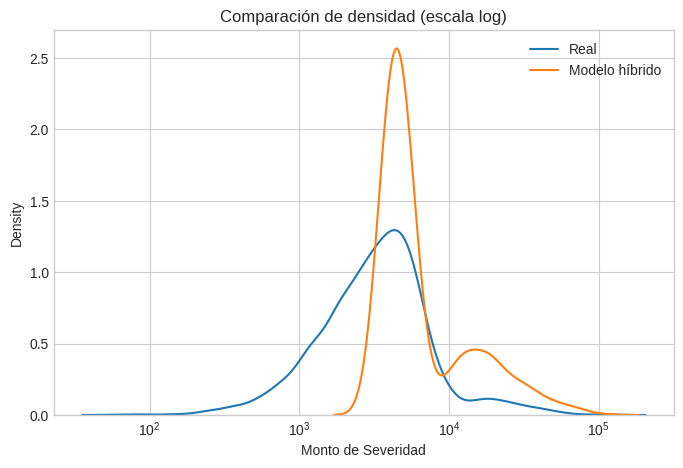

In [64]:
plt.figure(figsize=(8,5))
sns.kdeplot(claims, label="Real", log_scale=True)
sns.kdeplot(preds_hybrid_full, label="Modelo híbrido", log_scale=True)
plt.title("Comparación de densidad (escala log)")
plt.xlabel("Monto de Severidad")
plt.legend()
plt.show()

In [65]:
print(preds_body)

[1985.3383 4658.096  2820.0222 8888.238  2986.3362 3530.453  7321.095
 7227.8228 5614.1035 5667.116  3358.5854 1418.9677 6520.0493 9207.854
 3968.2444 3740.955  3801.131  7208.7407 3848.0217 2228.6853 4134.55
 5940.6562 2259.8108 8432.334  5293.458  6348.812  3607.1094 3195.7327
 2194.973  4463.017  2409.1238 5607.4414 3019.7307 2431.1643 3048.78
 4345.825  5874.431  6634.5654 4392.647  7658.356  3106.3425 5512.5625
 3369.1204 2071.3638 4614.373  4166.779  4037.876  1716.6626 4981.3774
 5020.408  7193.338  2379.0186 7363.389  2544.3003 2332.9663 4107.966
 3155.8003 6089.904  6144.4434 5862.5996 3439.0486 3284.1807 1635.6423
 3571.6633 8773.644  3225.8677 2490.8372 1768.2533 3279.7205 4186.4634
 5469.934  3593.1733 8797.581  3514.818  6231.04   3157.3132 2511.5115
 1600.5009 6000.762  2575.5886 9239.221  4216.0884 3151.4412 7542.76
 6300.289  2874.388  3412.4048 3415.9956 4738.812  5279.4272 2985.6316
 4011.8323 3683.7085 3270.6392 2308.2627 5233.519  1248.9879 2246.5623
 2646.7024 1650

In [66]:
# ===================== COTIZACIÓN FINAL — APLICACIÓN PRÁCTICA =====================
nuevo_asegurado = pd.DataFrame([{
    "MVR_PTS": 3,
    "CLM_FREQ": 0,
    "OCCUPATION": "Blue Collar",
    "EDUCATION": "PhD",
    "PARENT1": "No",
    "REVOKED": "No",
    "MSTATUS": "Yes",
    "OLDCLAIM": 0.0,
    "HOMEKIDS": 0,
    "CAR_USE": "Private",
    "AGE": 35.0,
    "FREQUENCY": 0,
    "SEVERITY": 0.0
}])

# 2) Construir X con el mismo esquema que usaste al entrenar (num + cat codificadas)
cols_modelo = list(num_cols_body) + list(cat_cols_body)
X_nuevo = nuevo_asegurado[cols_modelo].copy()

Xn_num = X_nuevo[num_cols_body].copy()
Xn_cat = X_nuevo[cat_cols_body].copy()
Xn_cat_enc = enc_body.transform(Xn_cat)  # <<< usa tu encoder entrenado
X_nuevo_enc = pd.concat([Xn_num.reset_index(drop=True), Xn_cat_enc.reset_index(drop=True)], axis=1)

# 3) Predicción de FRECUENCIA (ya en escala final)
freq_pred = float(model_freq.predict(X_nuevo_enc)[0])

# 4) Predicción de SEVERIDAD (el modelo del cuerpo predice en LOG; aplicamos tu misma corrección)
#    a) armamos el X de entrenamiento con el mismo esquema (num + cat encod)
bt_num = body_train[num_cols_body].copy()
bt_cat = body_train[cat_cols_body].copy()
bt_cat_enc = enc_body.transform(bt_cat)
Xtr_enc_body = pd.concat([bt_num.reset_index(drop=True), bt_cat_enc.reset_index(drop=True)], axis=1)

#    b) residuales en log para estimar sigma^2 (como en tu train_test_body)
ytr_log_true = np.log(body_train["SEVERITY"].clip(lower=1e-6))
res_log = ytr_log_true.values - model_body.predict(Xtr_enc_body)
sigma2 = float(np.mean(res_log**2))
corr = float(np.exp(0.5 * sigma2))  # corrección lognormal de tu función

#    c) predicción final en escala original (y clip opcional al umbral u del cuerpo)
sev_pred_log = float(model_body.predict(X_nuevo_enc)[0])
sev_pred = float(np.exp(sev_pred_log) * corr)
sev_pred = float(np.minimum(sev_pred, u))  # respeta el dominio del cuerpo (opcional, no cambia el modelo)

# 5) Primas
prima_pura = freq_pred * sev_pred
prima_con_loading = prima_pura * (1 + loading)

# 6) Resultado final (inputs + outputs)
cotizacion = nuevo_asegurado.copy()
cotizacion["freq_esperada"] = round(freq_pred, 5)
cotizacion["sev_esperada"] = round(sev_pred, 2)
cotizacion["prima_pura"] = round(prima_pura, 2)
cotizacion["prima_con_loading"] = round(prima_con_loading, 2)

print("=== Cotización estimada para el asegurado ===")
print(cotizacion[[
    "MVR_PTS","OCCUPATION","EDUCATION","AGE","CAR_USE",
    "freq_esperada","sev_esperada","prima_pura","prima_con_loading"
]])


=== Cotización estimada para el asegurado ===
   MVR_PTS   OCCUPATION EDUCATION   AGE  CAR_USE  freq_esperada  sev_esperada  \
0        3  Blue Collar       PhD  35.0  Private        1.01409        3081.5   

   prima_pura  prima_con_loading  
0     3124.91            3689.51  


In [67]:
# Filtrar registros reales con las mismas características
comparables = df_final[
    (df_final["OCCUPATION"] == "Blue Collar") &
    #(df_final["EDUCATION"] == "High School") &
    (df_final["AGE"] == 35) &
    (df_final["MVR_PTS"] == 3)
]

# Mostrar coincidencias
print(f"Se encontraron {len(comparables)} registros similares en df_final:")
display(comparables.head())


Se encontraron 9 registros similares en df_final:


,MVR_PTS,CLM_FREQ,OCCUPATION,EDUCATION,PARENT1,REVOKED,MSTATUS,OLDCLAIM,HOMEKIDS,CAR_USE,AGE,FREQUENCY,SEVERITY,ID
1351,3,1,Blue Collar,Bachelors,Yes,No,No,4645.0,4,Private,35.0,0,0.0,130470336
3291,3,2,Blue Collar,High School,No,No,No,5347.0,0,Commercial,35.0,0,0.0,316455627
3416,3,2,Blue Collar,<High School,No,No,Yes,13272.0,0,Commercial,35.0,0,0.0,327103894
4548,3,2,Blue Collar,Bachelors,No,Yes,No,31039.0,0,Commercial,35.0,1,3840.0,441024113
4765,3,0,Blue Collar,High School,No,No,Yes,0.0,2,Commercial,35.0,0,0.0,462775314


In [68]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00


In [69]:
# ===================== COTIZADOR CON WIDGETS  =====================
from IPython.display import display, clear_output
import ipywidgets as w

# --- helpers para opciones y rangos ---
def qminmax(s, qlo=0.01, qhi=0.99):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0.0, 1.0
    lo, hi = float(s.quantile(qlo)), float(s.quantile(qhi))
    if not np.isfinite(lo) or not np.isfinite(hi) or lo >= hi:
        lo, hi = float(s.min()), float(s.max())
    return lo, hi

def options_from(col):
    vals = (body_train[col].dropna().astype(str).value_counts().index.tolist())[:50]
    return vals if vals else [""]

# --- widgets según tus columnas ---
mvr_lo, mvr_hi = qminmax(body_train["MVR_PTS"])
old_lo, old_hi = qminmax(body_train["OLDCLAIM"])
age_lo, age_hi = qminmax(body_train["AGE"])
clm_lo, clm_hi = qminmax(body_train["CLM_FREQ"])

w_mvr     = w.IntSlider(description="MVR_PTS", min=int(mvr_lo), max=int(max(mvr_hi, mvr_lo+1)), step=1, value=3, continuous_update=False)
w_clm     = w.IntSlider(description="CLM_FREQ", min=int(clm_lo), max=int(max(clm_hi, clm_lo+1)), step=1, value=0, continuous_update=False)
w_occ     = w.Dropdown(description="OCCUPATION", options=options_from("OCCUPATION"), value="Blue Collar" if "Blue Collar" in options_from("OCCUPATION") else None)
w_edu     = w.Dropdown(description="EDUCATION",  options=options_from("EDUCATION"),  value="PhD" if "PhD" in options_from("EDUCATION") else None)
w_parent1 = w.Dropdown(description="PARENT1",    options=options_from("PARENT1"))
w_rev     = w.Dropdown(description="REVOKED",    options=options_from("REVOKED"))
w_mstat   = w.Dropdown(description="MSTATUS",    options=options_from("MSTATUS"))
w_old     = w.FloatSlider(description="OLDCLAIM", min=float(old_lo), max=float(old_hi), step=(old_hi-old_lo)/100 if old_hi>old_lo else 1.0, value=0.0, readout_format=".2f", continuous_update=False)
w_home    = w.IntSlider(description="HOMEKIDS", min=0, max=int(max(5, body_train["HOMEKIDS"].max() if "HOMEKIDS" in body_train else 5)), step=1, value=0, continuous_update=False)
w_use     = w.Dropdown(description="CAR_USE",    options=options_from("CAR_USE"), value="Private" if "Private" in options_from("CAR_USE") else None)
w_age     = w.IntSlider(description="AGE",       min=int(max(16, age_lo)), max=int(min(95, age_hi)), step=1, value=35, continuous_update=False)

btn = w.Button(description="Calcular cotización", button_style="primary")
out = w.Output()

# --- función que usa tus modelos y encoder directamente ---
def calcular(_):
    with out:
        clear_output()

        nuevo_asegurado = pd.DataFrame([{
            "MVR_PTS":   int(w_mvr.value),
            "CLM_FREQ":  int(w_clm.value),
            "OCCUPATION":str(w_occ.value),
            "EDUCATION": str(w_edu.value),
            "PARENT1":   str(w_parent1.value),
            "REVOKED":   str(w_rev.value),
            "MSTATUS":   str(w_mstat.value),
            "OLDCLAIM":  float(w_old.value),
            "HOMEKIDS":  int(w_home.value),
            "CAR_USE":   str(w_use.value),
            "AGE":       float(w_age.value),
            "FREQUENCY": 0,
            "SEVERITY":  0.0
        }])

        # === preparar input igual que en tu entrenamiento ===
        cols_modelo = list(num_cols_body) + list(cat_cols_body)
        X_nuevo = nuevo_asegurado[cols_modelo].copy()
        Xn_num = X_nuevo[num_cols_body].copy()
        Xn_cat = X_nuevo[cat_cols_body].copy()
        Xn_cat_enc = enc_body.transform(Xn_cat)
        X_nuevo_enc = pd.concat([Xn_num.reset_index(drop=True), Xn_cat_enc.reset_index(drop=True)], axis=1)

        # === predicciones ===
        freq_pred = float(model_freq.predict(X_nuevo_enc)[0])

        bt_num = body_train[num_cols_body].copy()
        bt_cat = body_train[cat_cols_body].copy()
        bt_cat_enc = enc_body.transform(bt_cat)
        Xtr_enc_body = pd.concat([bt_num.reset_index(drop=True), bt_cat_enc.reset_index(drop=True)], axis=1)

        ytr_log_true = np.log(body_train["SEVERITY"].clip(lower=1e-6))
        res_log = ytr_log_true.values - model_body.predict(Xtr_enc_body)
        sigma2 = float(np.mean(res_log**2))
        corr = float(np.exp(0.5 * sigma2))

        sev_pred_log = float(model_body.predict(X_nuevo_enc)[0])
        sev_pred = float(np.exp(sev_pred_log) * corr)
        try:
            sev_pred = float(np.minimum(sev_pred, u))
        except NameError:
            pass

        # === primas (usa tu loading definido antes) ===
        prima_pura = freq_pred * sev_pred
        prima_con_loading = prima_pura * (1 + loading)

        cotizacion = nuevo_asegurado.copy()
        cotizacion["freq_esperada"] = round(freq_pred, 5)
        cotizacion["sev_esperada"] = round(sev_pred, 2)
        cotizacion["prima_pura"] = round(prima_pura, 2)
        cotizacion["prima_con_loading"] = round(prima_con_loading, 2)
        col_map = {
            "MVR_PTS": "Puntuación del conductor",
            "CLM_FREQ": "# Siniestros (últimos 5 años)",
            "OCCUPATION": "Profesión",
            "EDUCATION": "Nivel educativo",
            "PARENT1": "Tiene hijos",
            "REVOKED": "Licencia suspendida",
            "MSTATUS": "Estado civil",
            "OLDCLAIM": "Monto siniestros previos",
            "HOMEKIDS": "Cantidad de hijos",
            "CAR_USE": "Uso del vehículo",
            "AGE": "Edad"
        }

        cols_es = [
            "Puntuación del conductor","Profesión","Nivel educativo","Edad","Uso del vehículo",
            "freq_esperada","sev_esperada","prima_pura","prima_con_loading"
        ]
        cotizacion_view = cotizacion.rename(columns=col_map)
        display(cotizacion_view[cols_es])


btn.on_click(calcular)

# --- mostrar interfaz ---
ui_left  = w.VBox([w_mvr, w_clm, w_old, w_home, w_age])
ui_right = w.VBox([w_occ, w_edu, w_parent1, w_rev, w_mstat, w_use])
display(w.HBox([ui_left, w.Label("   "), ui_right]))
display(btn, out)
# ===================== FIN COTIZADOR CON WIDGETS =====================


Button(button_style='primary', description='Calcular cotización', style=ButtonStyle())

Output()